# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load original dataframes
allDataOrig = pd.read_csv("../Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM') #all feature dataset
hemoOrig = pd.read_csv("../Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM') #dataset with only hemodynamics
classLabels  = pd.read_csv("../Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM') #labels for prediction classes 

# Cluster Labels

In [3]:
#CLUSTERING FUNCTIONS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)
    
def kMeans(X, K): #perform k means clustering
    km = KMeans(n_clusters=K, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    print("Lowest SSE", km.inertia_) #lowest sum of squared error value
    print("Number of iterations needed for convergence", km.n_iter_) #number of iterations neded to converge
    print("Y_km labels", y_km)
    
    return y_km

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return df

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

        print("Cluster ", num)
        print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

#compare distributions of clusters
def distPlotsForClusters(cls, cols, name):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Figures/" + name + "/Clusters"+c+".png")

## Hemo Dataset

In [4]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoOrig)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

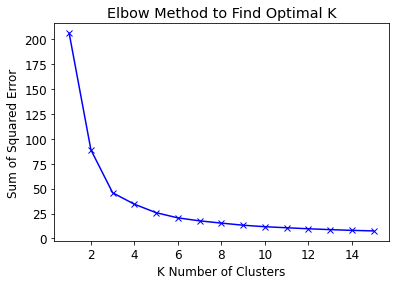

Using the elbow method, the optimal number of clusters is 3


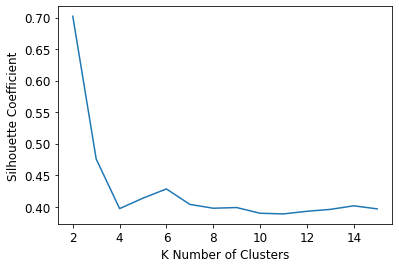

Using Silhouette Scores, the optimal number of clusters is 2


In [5]:
clusterFindK(data)

Lowest SSE 25.831284441802524
Number of iterations needed for convergence 16
Y_km labels [0 4 2 2 4 2 4 3 4 1 0 1 1 3 3 2 1 3 1 1 4 4 4 1 0 1 0 3 1 1 1 3 1 2 4 4 4
 1 2 2 0 4 4 1 4 1 4 1 1 1 4 1 1 3 0 2 0 4 4 1 1 1 1 3 0 4 4 1 1 3 1 4 1 3
 0 3 4 1 4 1 1 4 0 1 1 1 1 1 2 1 4 4 1 2 3 1 0 3 1 1 1 1 4 4 4 2 4 2 4 1 4
 4 0 3 4 1 4 1 3 1 4 2 2 1 1 1 1 1 0 1 1 1 1 1 4 2 4 1 4 1 0 4 4 1 0 1 1 1
 4 1 4 1 0 4 1 2 4 3 2 4 4 3 4 1 0 4 1 1 1 3 4 1 2 2 1 1 0 4 4 1 4 4 1 1 4
 1 4 1 4 1 4 2 3 1 2 2 4 1 0 4 1 2 4 1 1 2 4 1 1 1 4 1 1 1 0 1 4 4 0 4 1 2
 4 3 1 1 1 1 4 1 4 4 1 1 4 3 4 2 1 2 4 1 0 2 2 2 4 1 1 3 4 2 4 1 4 3 4 1 0
 4 4 1 4 1 0 4 0 3 3 1 4 1 0 4 0 1 2 2 4 1 4 1 0 2 4 4 4 4 1 1 2 2 1 1 4 1
 2 2 4 1 0 4 4 4 0 4 0 4 0 4 4 2 4 1 2 1 4 1 4 1 4 4 0 3 4 1 4 4 0 4 4 1 4
 3 4 3 4 1 0 4 1 1 0 4 2 1 3 2 0 4 0 0 4 4 4 4 1 4 0 3 4 1 0 1 1 3 0 0 0 2
 0 4 4 4 0 0 4 4 0 4 0 1 4 1 4 4 4 1 2 2 0 4 0 1 0 1 1 4 3 1 1 1 0 0 4 2 2
 3 0 0 4 1 2 3 0 4 4 4]


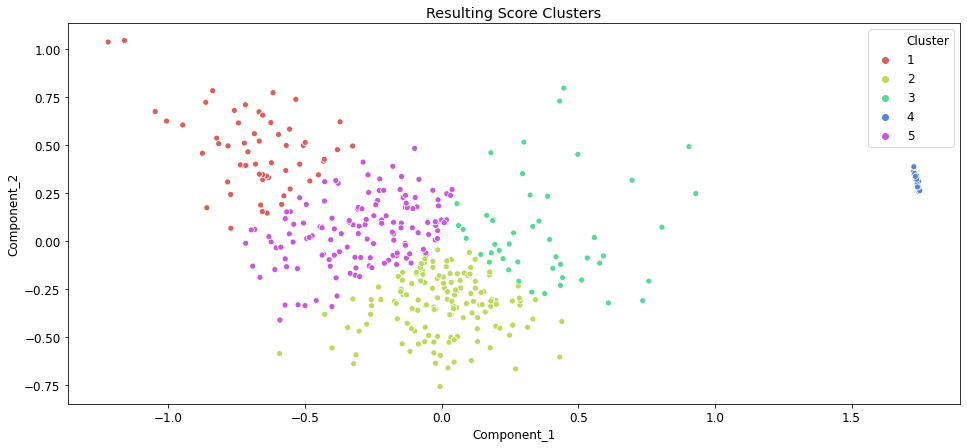

In [6]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5, "Hemo")

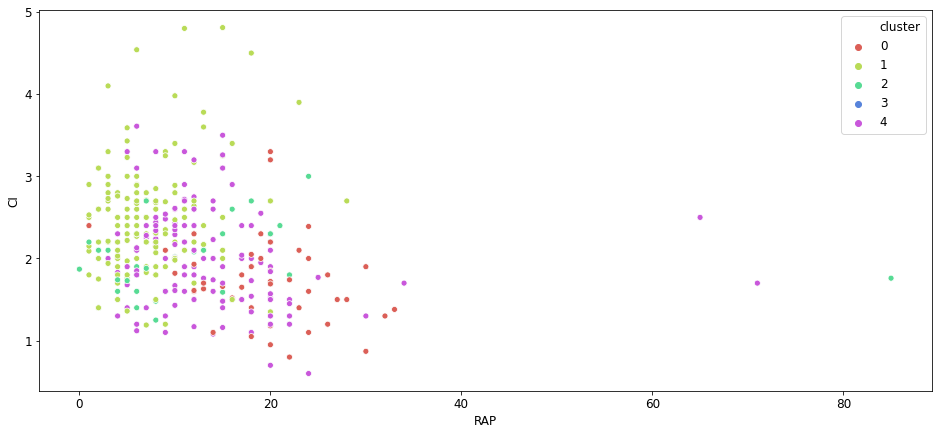

In [7]:
#Look at original data clusters
hemoDF = plotClusters(hemoOrig, y_km, ["RAP", "CI"], 5)

In [8]:
#Add class labels
hemoDF['Death'] = classLabels['Death']
hemoDF['Rehosp'] = classLabels['Rehosp']
hemoDF['Readmission'] = classLabels['Readmission']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
             RAP        PAS        PAD       PAMN       PCWP    PCWPMod  \
count  56.000000  57.000000  57.000000  57.000000  57.000000  57.000000   
mean   18.553571  68.526316  37.877193  48.017544  34.947368  34.947368   
std     6.412827  10.380451   6.758778   9.138793   6.434897   6.434897   
min     1.000000  42.000000  20.000000  16.000000  20.000000  20.000000   
25%    13.750000  63.000000  35.000000  43.000000  30.000000  30.000000   
50%    19.000000  69.000000  37.000000  49.000000  35.000000  35.000000   
75%    22.250000  74.000000  42.000000  53.000000  39.000000  39.000000   
max    33.000000  90.000000  59.000000  82.000000  53.000000  53.000000   

           PCWPA     PCWPMN         CO         CI  ...       PAPP  \
count  46.000000  46.000000  55.000000  54.000000  ...  57.000000   
mean   35.217391  33.891304   3.516000   1.748519  ...   0.441638   
std     7.001311   5.275639   1.048398   0.489522  ...   0.093725   
min    20.000000  20.000000   1.68000

              RAP         PAS        PAD        PAMN        PCWP     PCWPMod  \
count  135.000000  137.000000  137.00000  136.000000  131.000000  137.000000   
mean    13.400000   55.554745   26.59854   36.639706   23.404580   24.014599   
std      8.732509    9.964584    5.12270    7.808517    4.538347    5.335764   
min      3.000000   38.000000   16.00000    9.000000    0.000000    0.000000   
25%      8.500000   49.000000   24.00000   32.000000   20.000000   20.000000   
50%     12.000000   55.000000   25.00000   35.000000   23.000000   24.000000   
75%     17.000000   60.000000   30.00000   41.000000   26.000000   27.000000   
max     71.000000   89.000000   45.00000   74.000000   36.000000   45.000000   

            PCWPA     PCWPMN          CO         CI  ...        PAPP  \
count  104.000000  81.000000  134.000000  131.00000  ...  137.000000   
mean    23.307692  22.543210    3.940373    2.02855  ...    0.514071   
std      4.684361   5.174576    1.249116    0.58970  ...    0.0

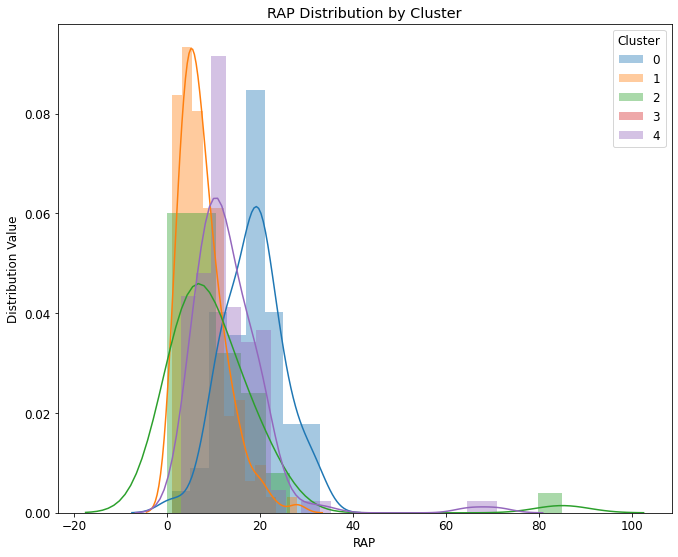

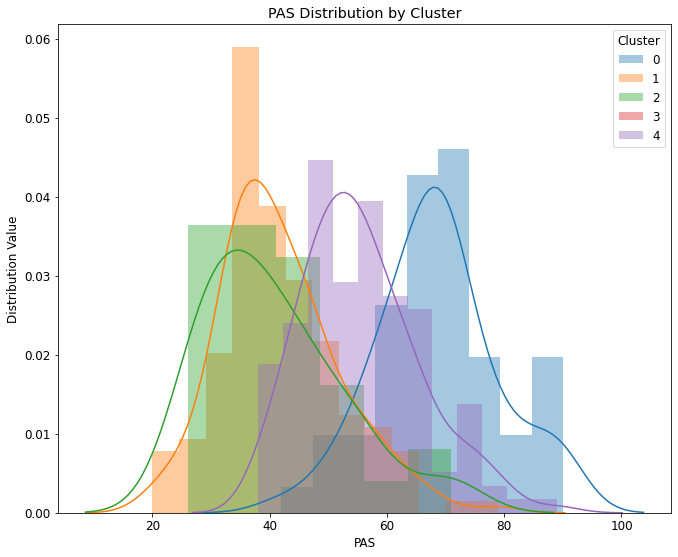

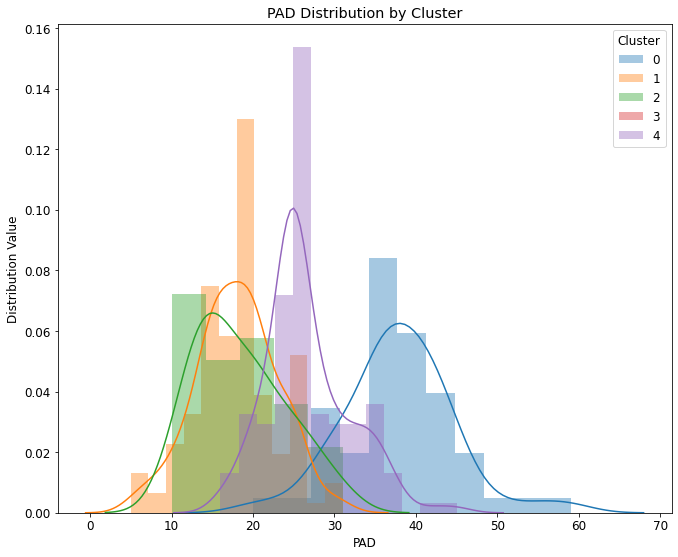

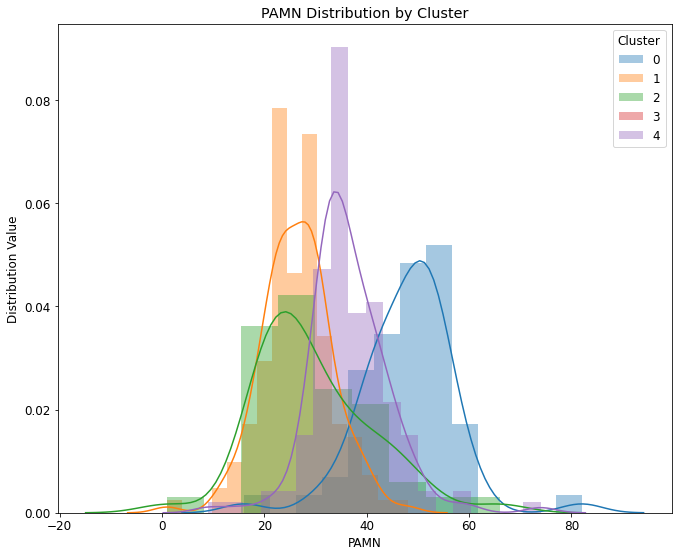

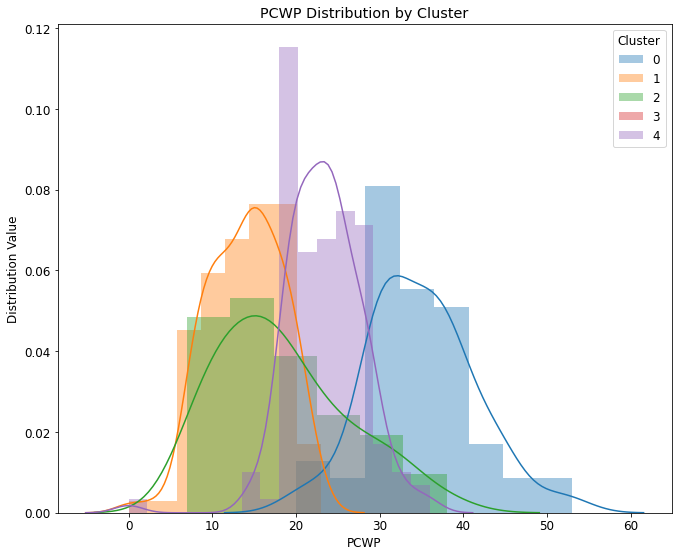

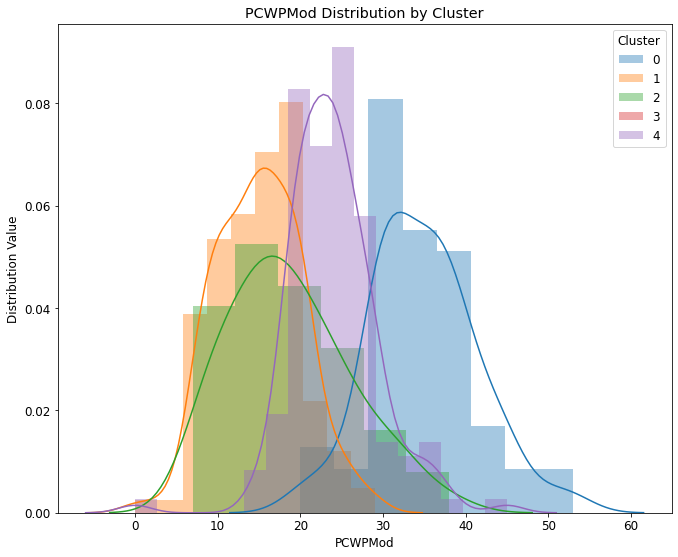

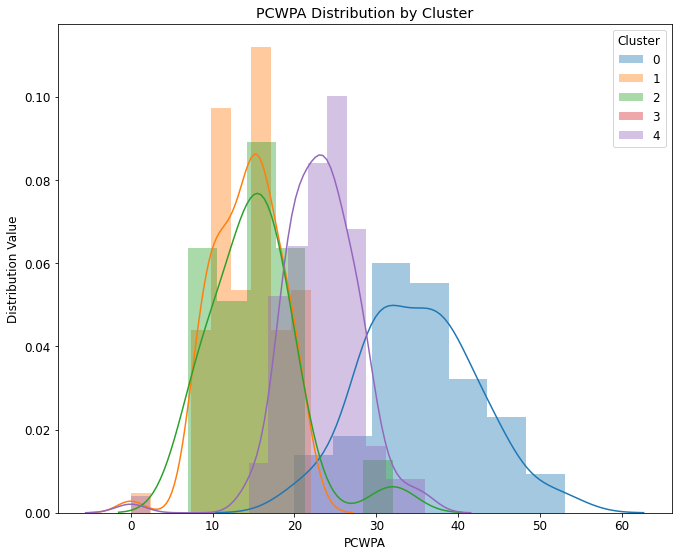

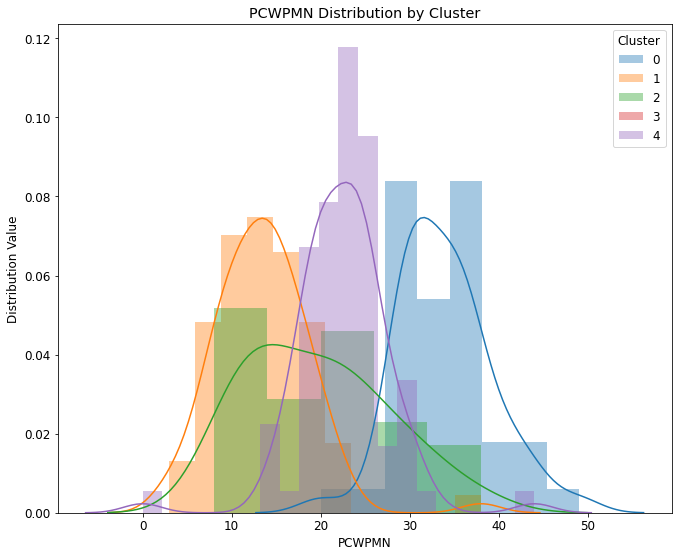

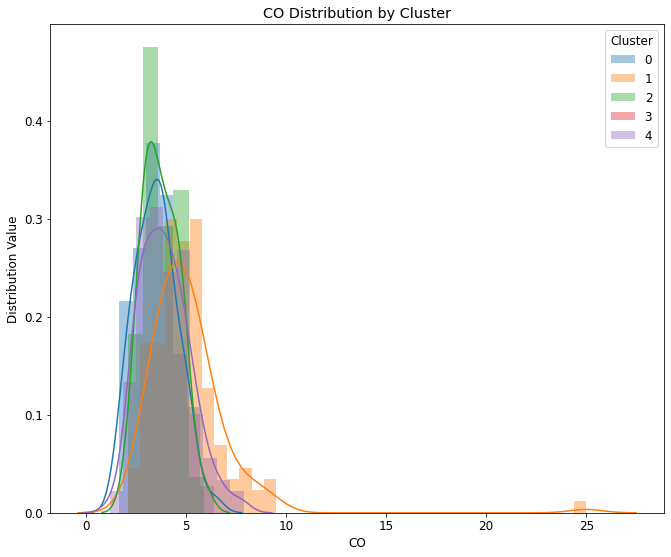

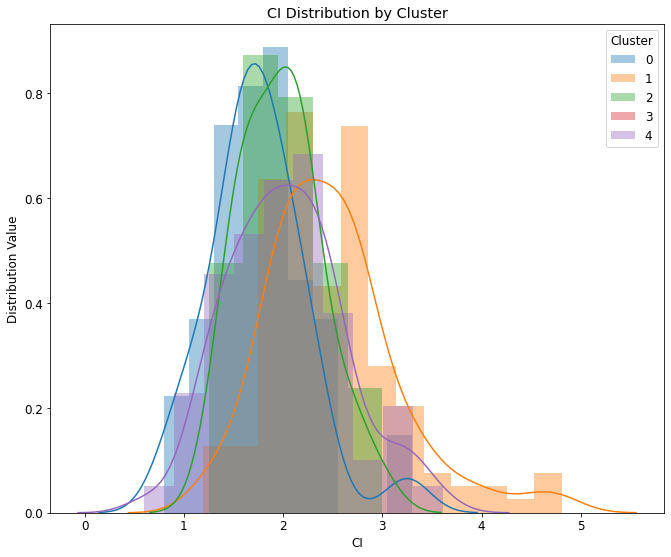

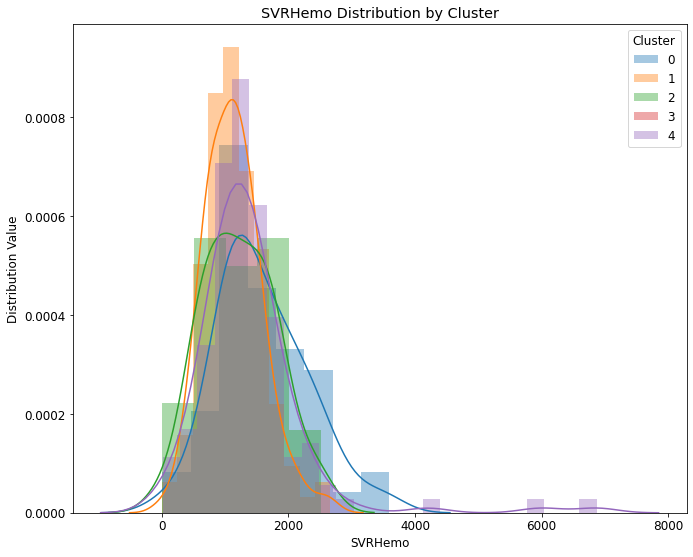

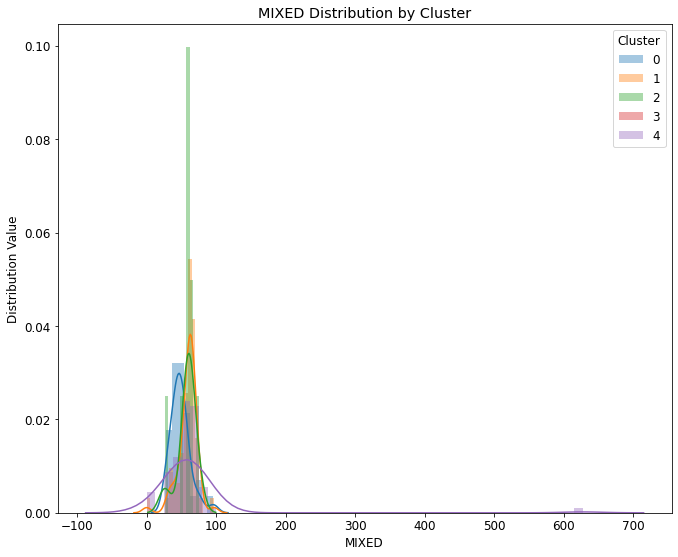

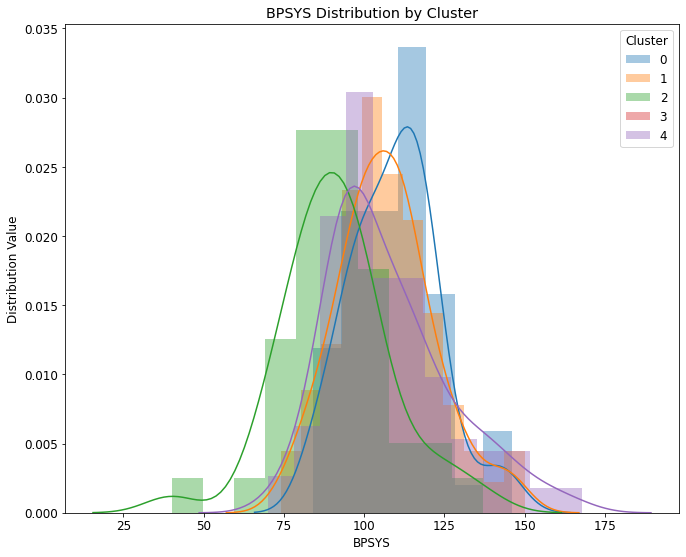

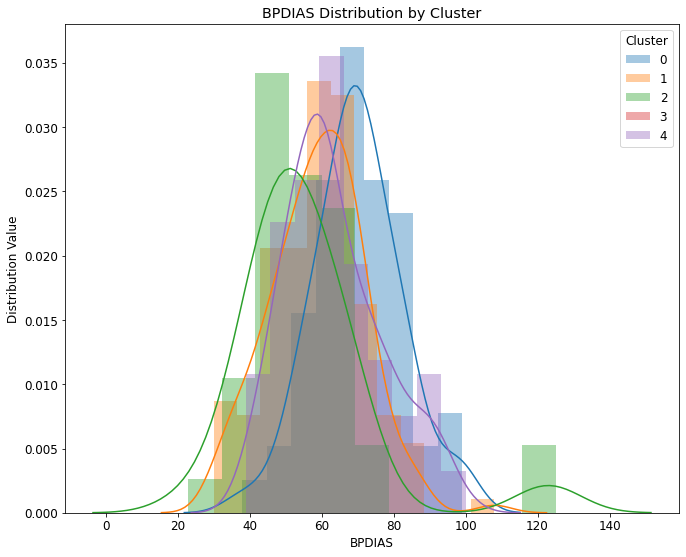

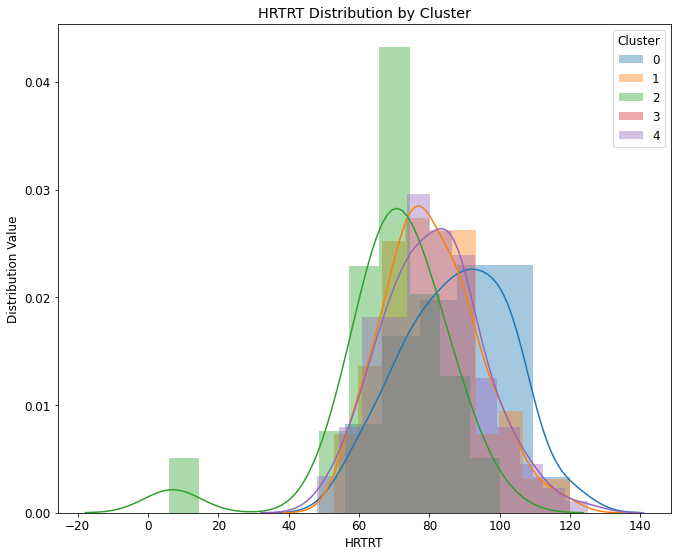

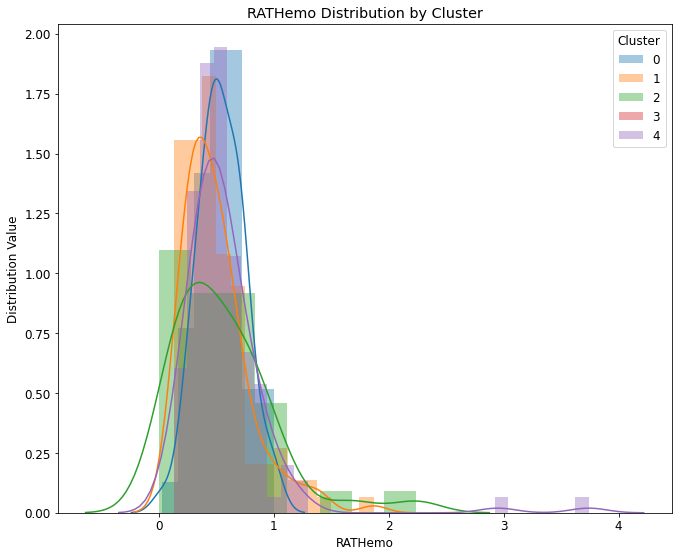

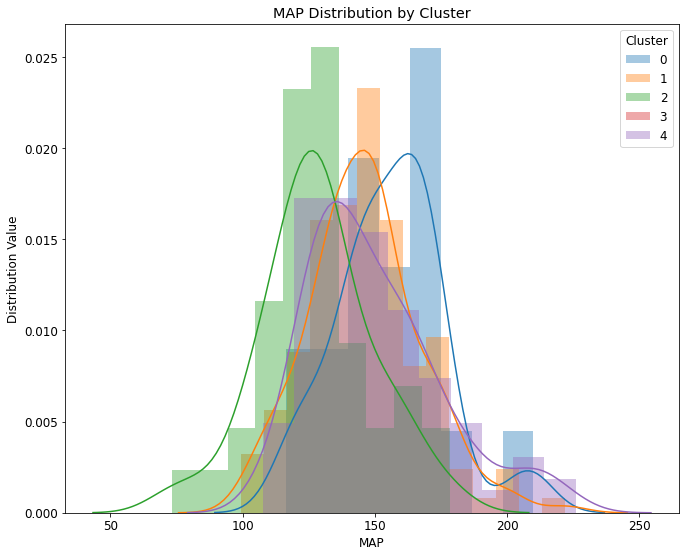

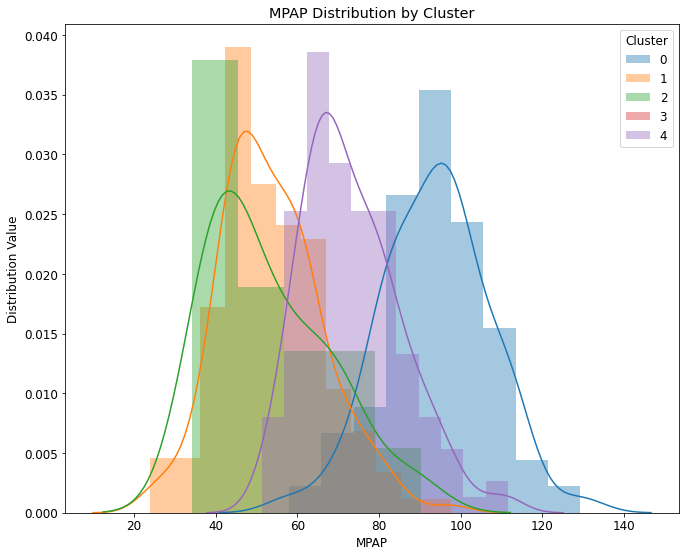

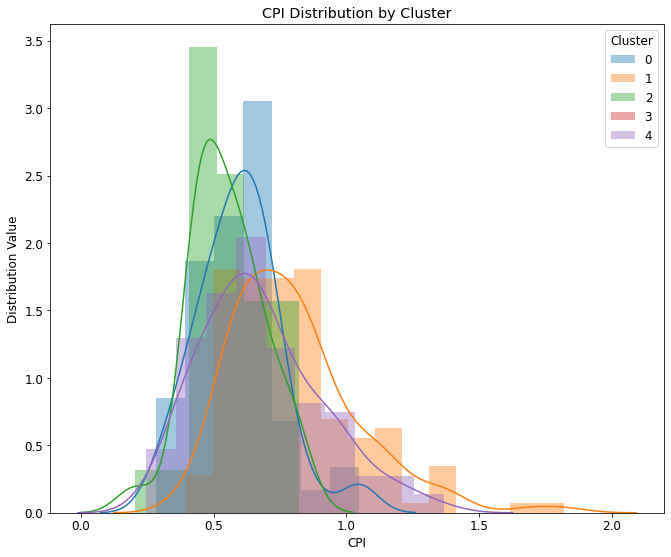

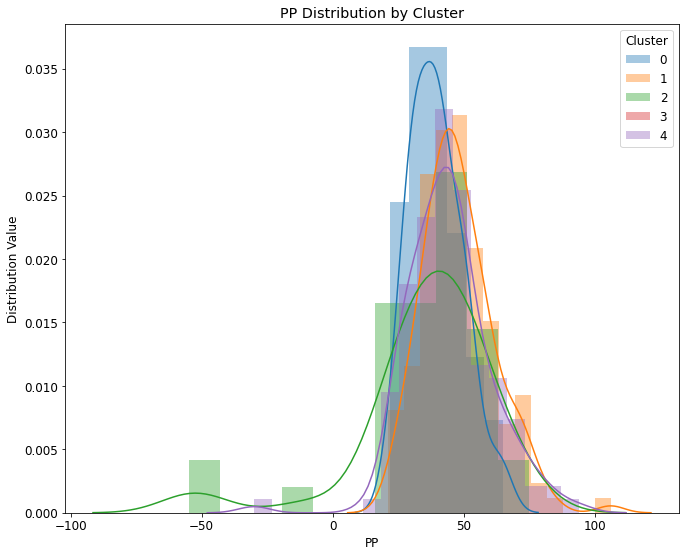

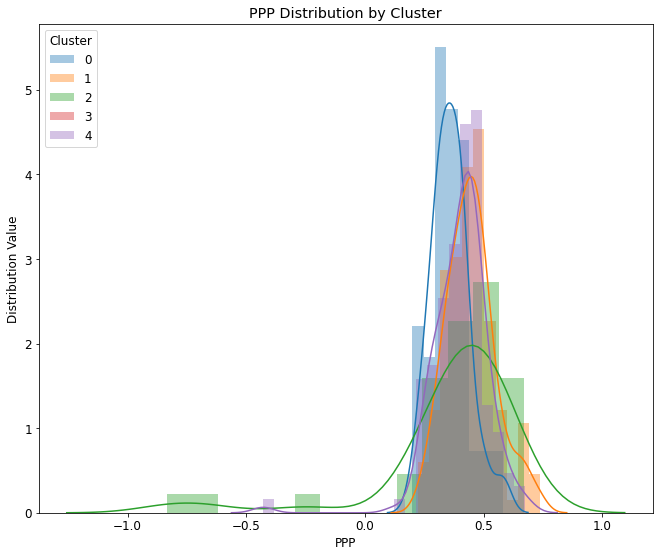

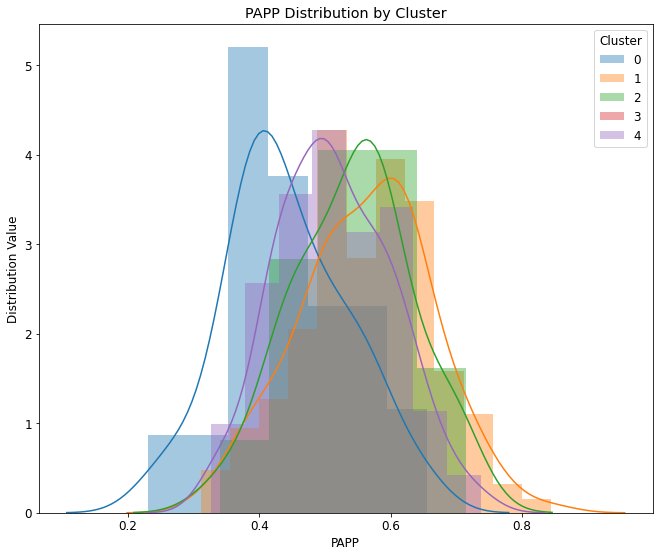

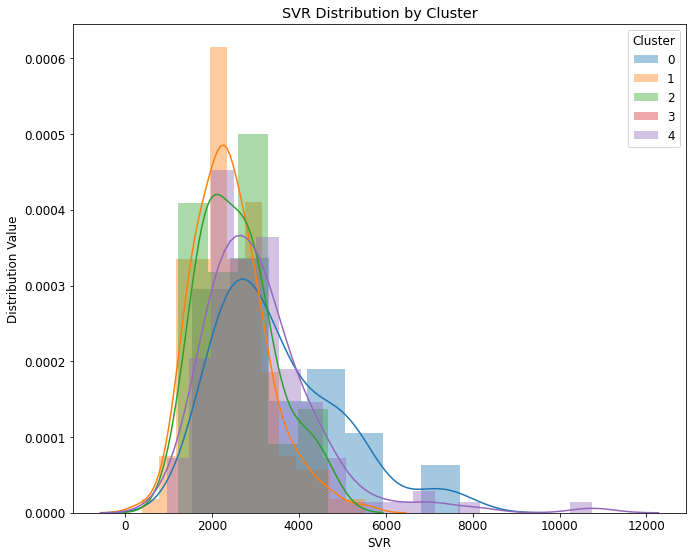

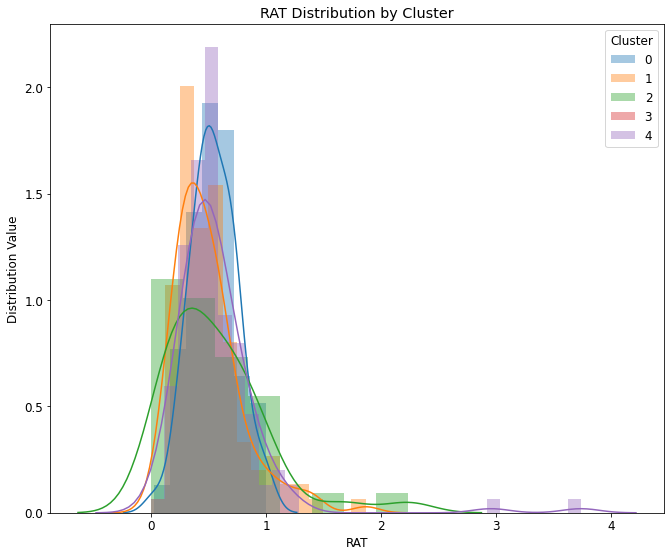

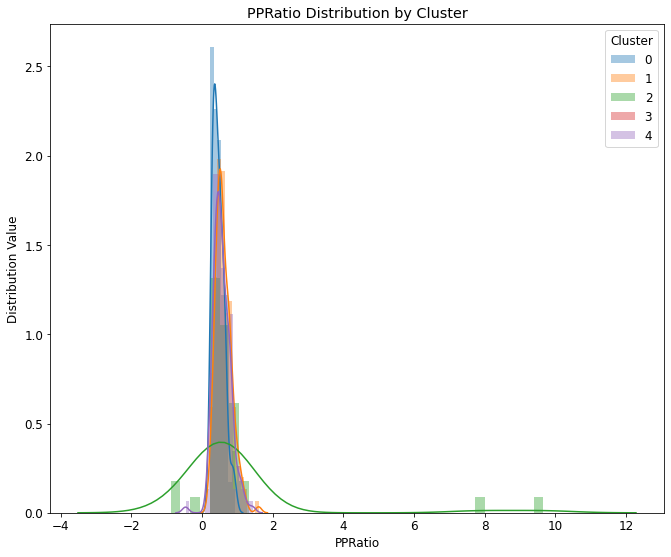

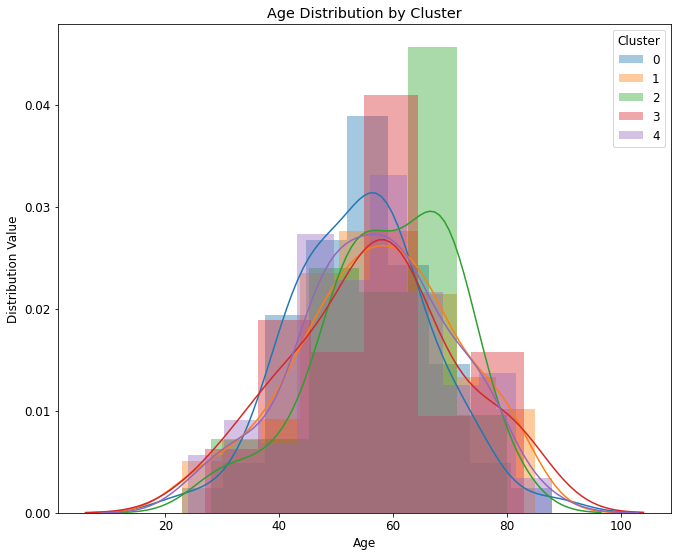

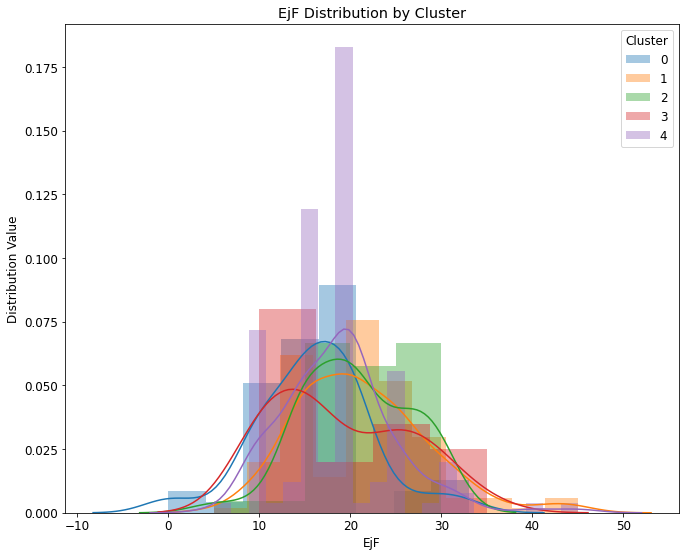

In [9]:
colss = ['RAP', 'PAS', 'PAD', 'PAMN', 'PCWP', 'PCWPMod', 'PCWPA', 'PCWPMN', 'CO',
       'CI', 'SVRHemo', 'MIXED', 'BPSYS', 'BPDIAS', 'HRTRT', 'RATHemo', 'MAP',
       'MPAP', 'CPI', 'PP', 'PPP', 'PAPP', 'SVR', 'RAT', 'PPRatio', 'Age',
       'EjF']

distPlotsForClusters(cls=clusters, cols=colss, name="Hemo")

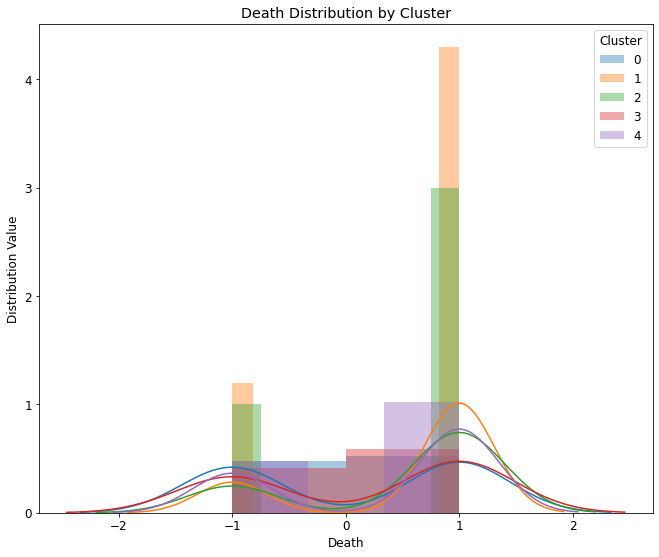

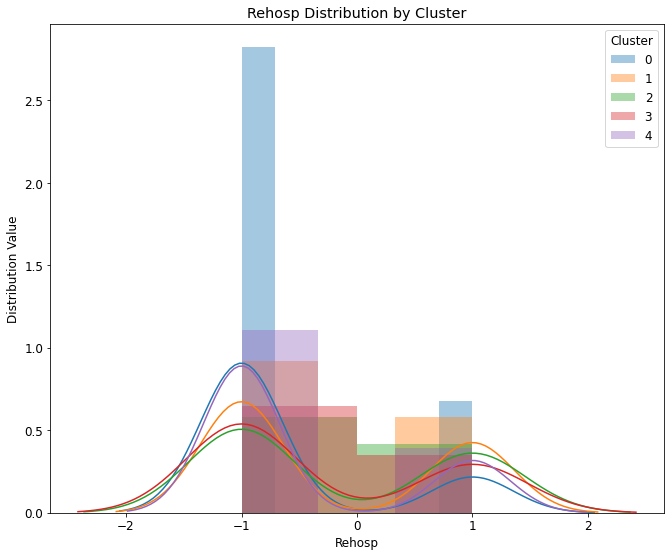

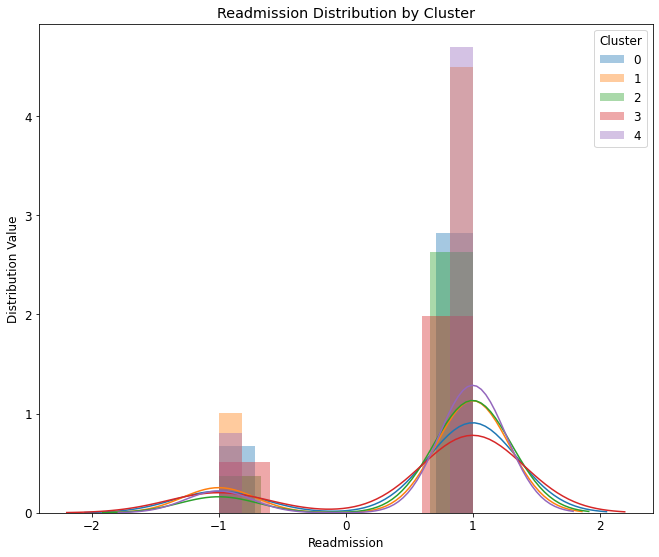

In [10]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss, name="Hemo")

In [11]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo.csv")

In [12]:
hemoDF.to_csv("Clustered_HemoDF.csv")

Save preprocessed data  
Cluster --> Score  
0 --> 5  
1 --> 2  
2 --> 1  
3 --> 4  
4 --> 3  

In [13]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(2)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
    
hemoDF['Score'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(1)
    elif c == 2:
        labels.append(2)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
hemoDF['ScoreDeath'] = labels

#Rehosp Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(2)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(3)
    elif c == 4:
        labels.append(4)
    else:
        pass
hemoDF['ScoreRehosp'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(4)
    elif c == 1:
        labels.append(3)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(5)
    elif c == 4:
        labels.append(2)
    else:
        pass
hemoDF['ScoreReadmission'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])
hemoDF = hemoDF.drop(columns=["Rehosp"])
hemoDF = hemoDF.drop(columns=["Readmission"])

hemoDF

RAP   PAS   PAD  PAMN  PCWP  PCWPMod  PCWPA  PCWPMN    CO    CI  \
DEIDNUM                                                                     
72       24.0  42.0  24.0  30.0  36.0     36.0   36.0    36.0  2.20  1.60   
72       18.0  42.0  24.0  30.0  24.0     24.0   24.0    28.0  3.10  2.00   
81       10.0  40.0  20.0  27.0  18.0     18.0   18.0    20.0  4.52  2.02   
81       12.0  35.0  15.0  25.0  17.0     17.0   17.0    14.0  4.65  2.08   
814       3.0  51.0  19.0  30.0  18.0     18.0   18.0    18.0  4.10  2.00   
...       ...   ...   ...   ...   ...      ...    ...     ...   ...   ...   
98508     NaN   NaN   NaN   NaN   NaN      NaN    NaN     NaN   NaN   NaN   
99302    19.0  87.0  37.0  54.0  44.0     44.0   44.0     NaN  3.90  2.00   
99302    11.0  70.0  28.0  44.0  28.0     28.0   28.0     NaN  5.30  2.70   
99935     8.0  49.0  29.0  31.0  15.0     15.0   15.0    26.0  4.00  2.40   
99935     8.0  52.0  24.0  39.0  24.0     24.0   24.0    24.0  5.60  3.30   

         ...      PAPP          SVR       RAT   PPRatio   Age   EjF  Score  \
DEIDNUM  ...                                                                 
72       ...  0.428571  5357.575758  0.666667  0.266667  88.0  25.0      5   
72       ...  0.428571  3509.677419  0.750000  0.272727  88.0  25.0      3   
81       ...  0.500000  1982.300885  0.555556  0.242857  69.0  20.0      1   
81       ...  0.571429  1772.043011  0.705882  0.571429  69.0  20.0      1   
814      ...  0.627451  2621.138211  0.166667  0.566667  58.0   NaN      3   
...      ...       ...          ...       ...       ...   ...   ...    ...   
98508    ...       NaN          NaN       NaN       NaN  57.0  30.0      4   
99302    ...  0.574713  2666.666667  0.431818  0.642857  41.0  15.0      5   
99302    ...  0.600000  2440.251572  0.392857  1.088608  41.0  15.0      3   
99935    ...  0.408163  3220.000000  0.533333  1.253333  64.0  20.0      3   
99935    ...  0.538462  1985.714286  0.333333  0.888889  64.0  20.0      3   

         ScoreDeath  ScoreRehosp  ScoreReadmission  
DEIDNUM                                             
72                5            5                 4  
72                3            4                 2  
81                2            1                 1  
81                2            1                 1  
814               3            4                 2  
...             ...          ...               ...  
98508             4            3                 5  
99302             5            5                 4  
99302             3            4                 2  
99935             3            4                 2  
99935             3            4                 2  

[418 rows x 31 columns]

In [14]:
hemoDF.to_csv("../Data/Preprocessed Data/Cluster_Hemo.csv")

## All Data

In [15]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataOrig)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

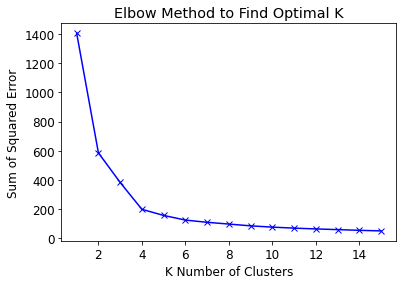

Using the elbow method, the optimal number of clusters is 4


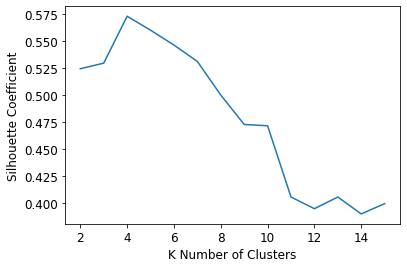

Using Silhouette Scores, the optimal number of clusters is 4


In [16]:
clusterFindK(data)

Lowest SSE 156.41886253798353
Number of iterations needed for convergence 6
Y_km labels [1 1 2 2 0 0 1 1 1 1 0 0 2 2 4 4 1 1 2 2 3 3 0 0 2 2 1 1 1 1 0 0 3 3 2 2 3
 3 1 1 3 3 0 0 1 1 0 0 2 2 1 1 0 0 3 3 1 1 3 3 1 1 1 1 2 2 3 3 1 1 1 1 1 1
 1 1 1 1 2 2 4 4 3 3 2 2 1 1 0 0 0 0 0 0 3 3 2 2 4 4 3 3 2 2 0 0 1 1 0 0 0
 0 0 0 2 2 1 1 1 1 1 1 2 2 0 0 0 0 1 1 3 3 0 0 0 0 0 0 3 3 0 0 0 0 1 1 1 1
 3 3 0 0 3 3 2 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 1 1 3 3 1 1 1 1 3 3 2 2 2 2 4
 4 0 0 0 0 1 1 4 4 2 2 2 2 2 2 0 0 1 1 1 1 2 2 1 1 2 2 3 3 3 3 3 3 3 3 3 3
 0 0 4 4 0 0 0 0 2 2 4 4 1 1 0 0 0 0 0 0 1 1 1 1 2 2 4 4 4 4 3 3 0 0 4 4 2
 2 4 4 1 1 2 2 3 3 0 0 3 3 3 3 3 3 3 3 1 1 3 3 1 1 4 4 1 1 2 2 1 1 1 1 0 0
 4 4 0 0 1 1 3 3 0 0 0 0 1 1 1 1 1 1 2 2 0 0 4 4 2 2 3 3 0 0 0 0 0 0 0 0 1
 1 1 1 2 2 1 1 1 1 2 2 2 2 0 0 2 2 4 4 4 4 0 0 4 4 3 3 2 2 2 2 3 3 4 4 0 0
 4 4 2 2 2 2 4 4 2 2 2 2 0 0 0 0 0 0 2 2 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1
 1 1 1 3 3 0 0 0 0 3 3 1 1 0 0 0 0 4 4 2 2 0 0 0 0 0 0 3 3 0 0 2 2 3 3 4 4
 4 4 1 1 0 0

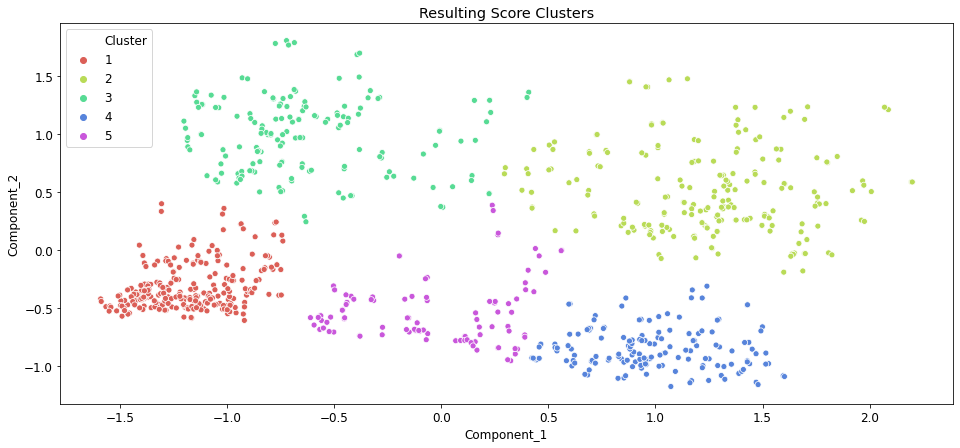

In [17]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5, 'AllData')

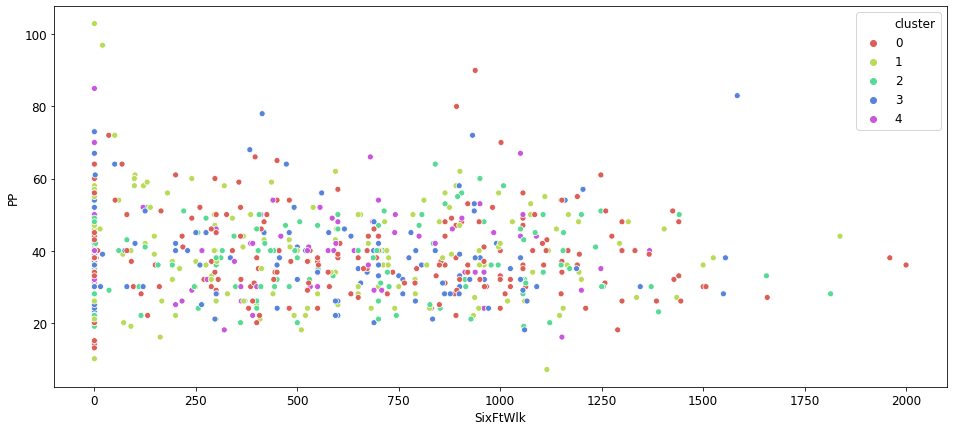

In [18]:
#Look at original data clusters
allDF = plotClusters(allDataOrig, y_km, ["SixFtWlk", "PP"], 5)

In [19]:
#Add class labels
allDF['Death'] = classLabels['Death']
allDF['Rehosp'] = classLabels['Rehosp']
allDF['Readmission'] = classLabels['Readmission']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
              Age      Gender        Race          Wt         BMI  \
count  254.000000  254.000000  254.000000  240.000000  237.000000   
mean    47.370079    1.417323    4.236220   83.142955   29.027806   
std     14.151525    0.494091   14.646537   22.129312    7.568534   
min     20.000000    1.000000    1.000000   47.000000   16.439909   
25%     37.250000    1.000000    1.000000   63.984091   23.281250   
50%     48.000000    1.000000    2.000000   83.350000   27.257807   
75%     56.000000    2.000000    2.000000   97.286364   33.805698   
max     85.000000    2.000000   98.000000  134.000000   52.734375   

       InitialHospDays  TotalHospDays        NYHA       MLHFS     AF  ...  \
count       246.000000     254.000000  242.000000  250.000000  250.0  ...   
mean          7.203252      14.645669    3.289256   76.712000    0.0  ...   
std           3.969186      20.374955    0.868423   16.161244    0.0  ...   
min           2.000000       1.000000    1.000000    8.0000

Cluster  4
             Age     Gender       Race          Wt        BMI  \
count  96.000000  96.000000  96.000000   90.000000  90.000000   
mean   57.354167   1.229167   3.791667   79.783131  27.582448   
std    11.479024   0.422503  13.851784   21.370704   7.088562   
min    34.000000   1.000000   1.000000   47.100000  15.642536   
25%    48.750000   1.000000   1.000000   65.000000  22.416083   
50%    56.500000   1.000000   1.500000   75.877273  25.494957   
75%    67.250000   1.000000   2.000000   87.179545  29.401277   
max    83.000000   2.000000  98.000000  134.000000  48.990635   

       InitialHospDays  TotalHospDays       NYHA       MLHFS         AF  ...  \
count        96.000000      96.000000  94.000000   96.000000  96.000000  ...   
mean          8.020833      12.750000   3.297872   73.354167   0.020833  ...   
std           6.319526      12.079561   0.745305   18.274503   0.143576  ...   
min           2.000000       1.000000   1.000000   26.000000   0.000000  ...   
25%

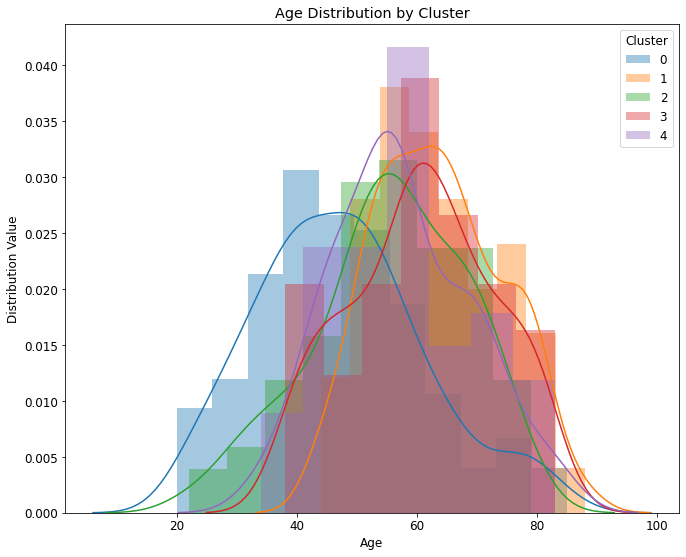

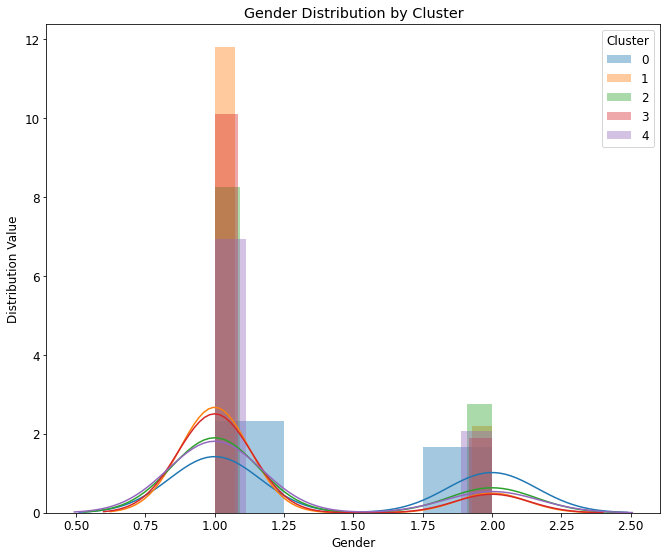

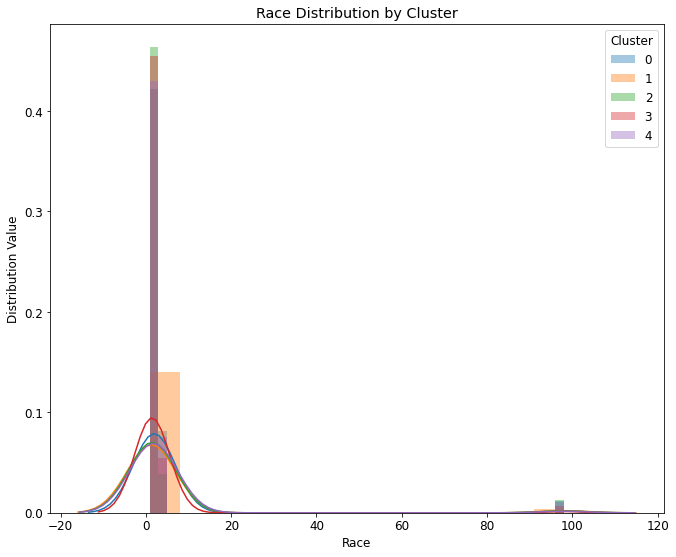

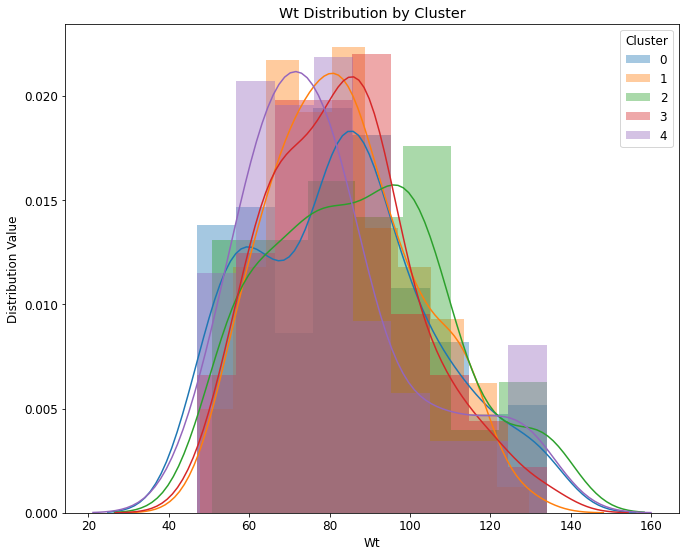

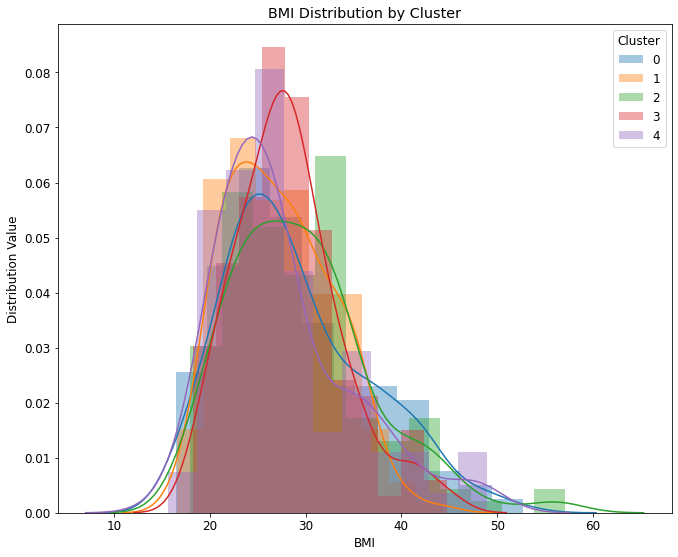

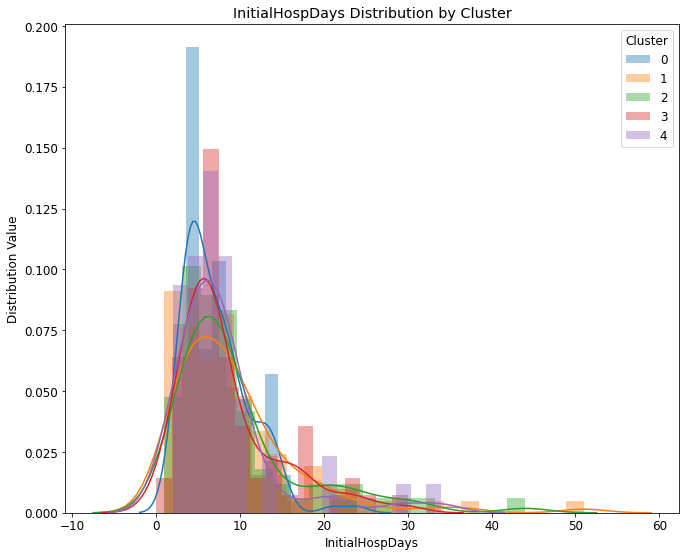

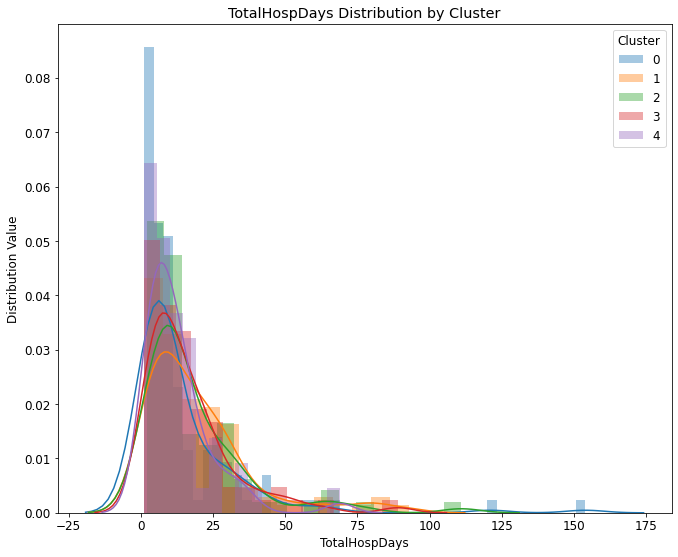

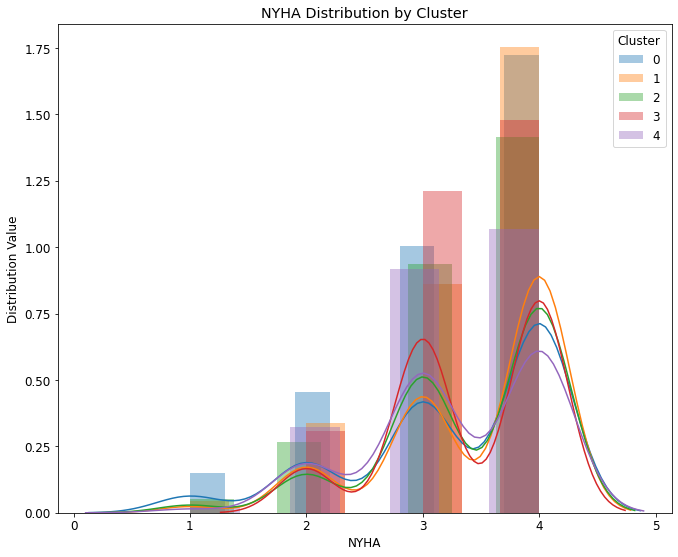

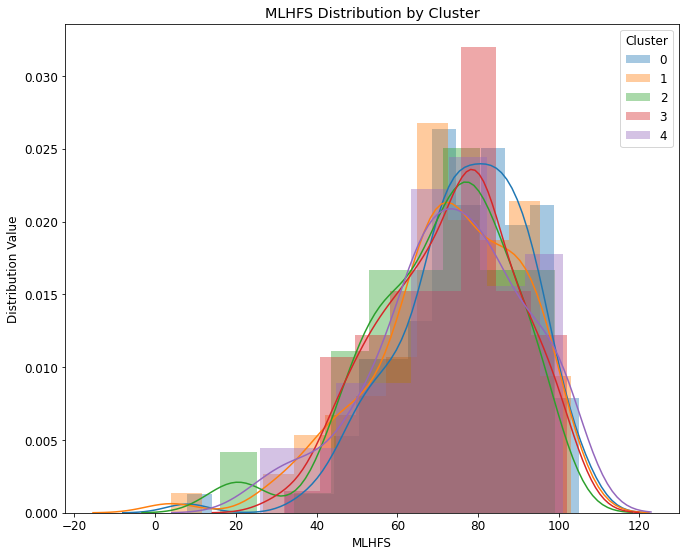

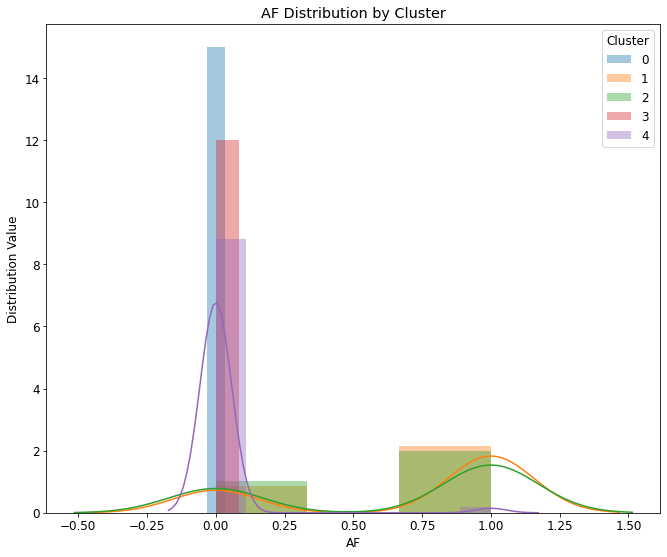

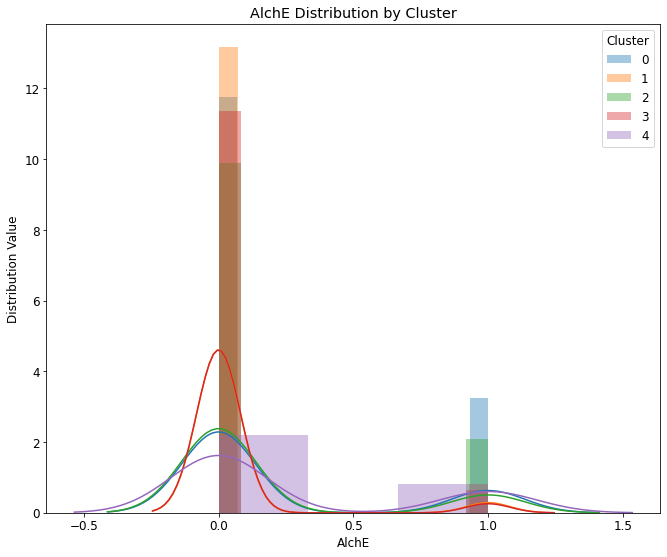

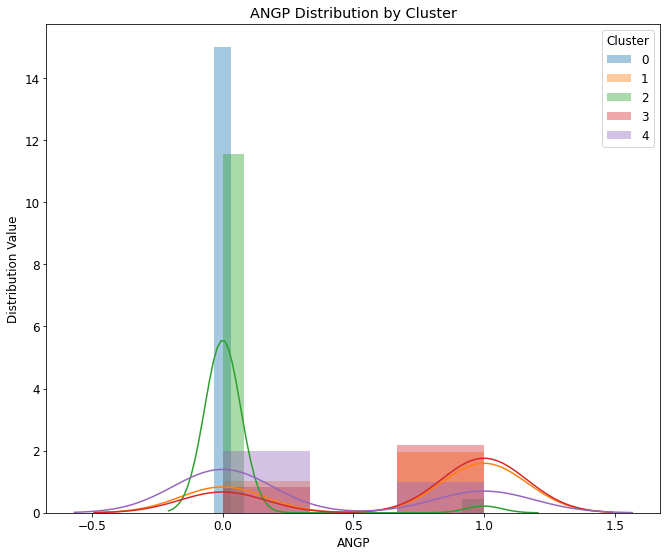

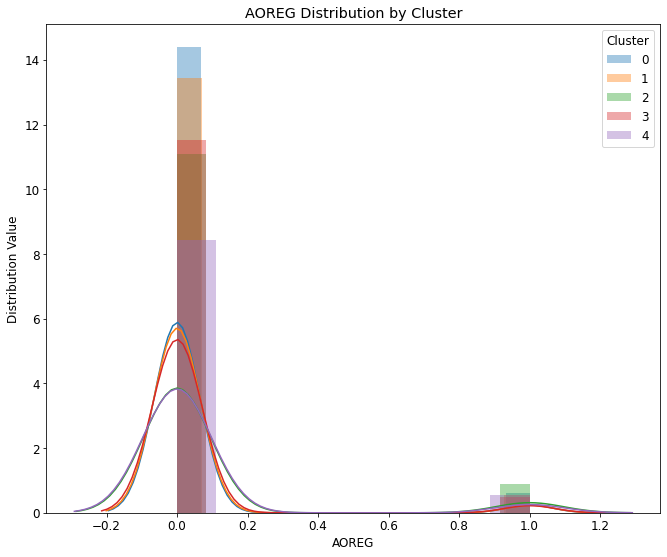

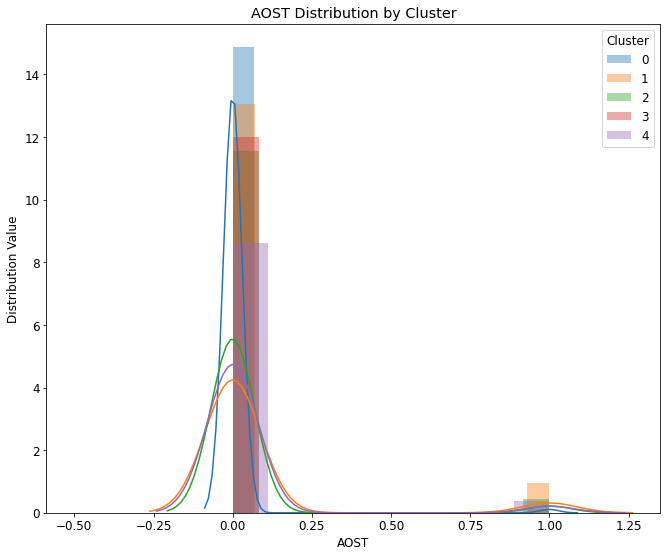

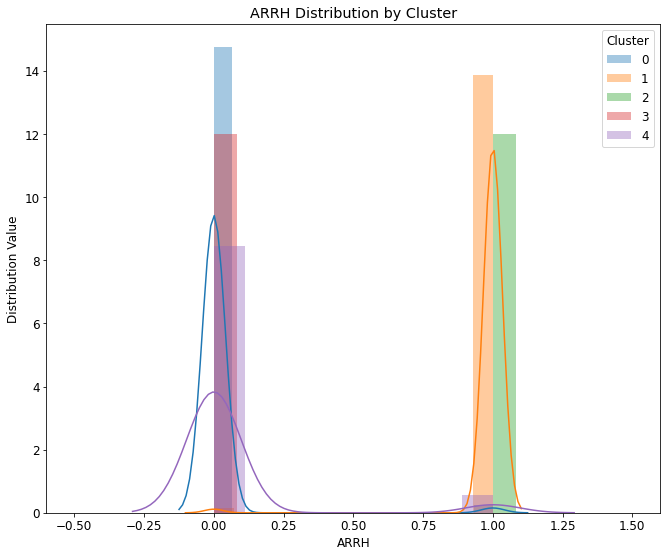

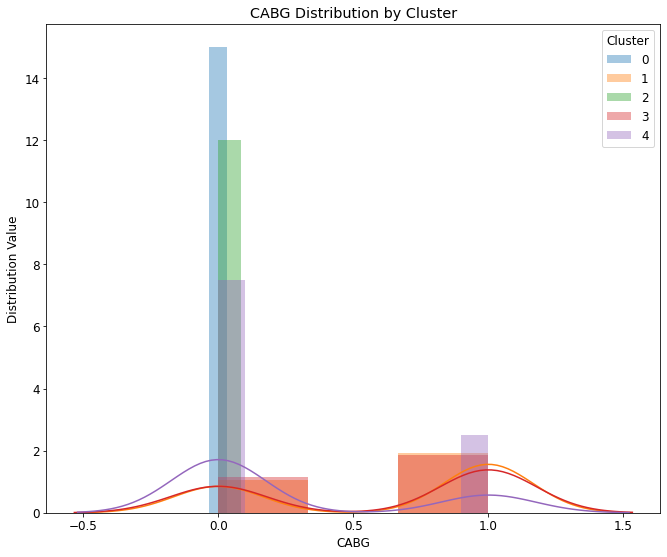

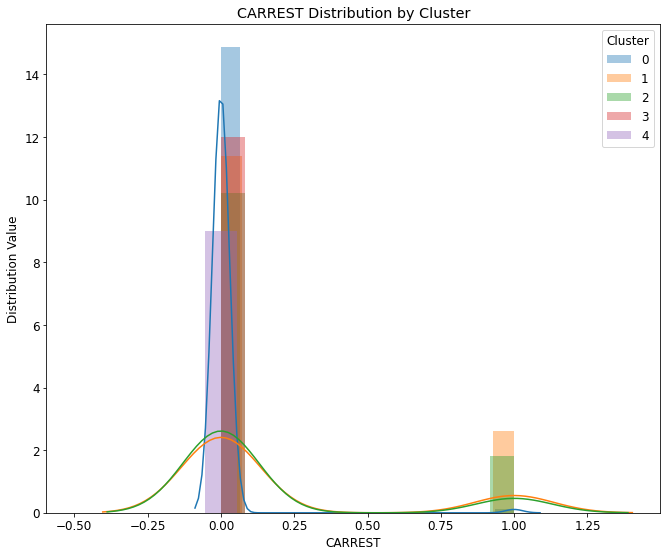

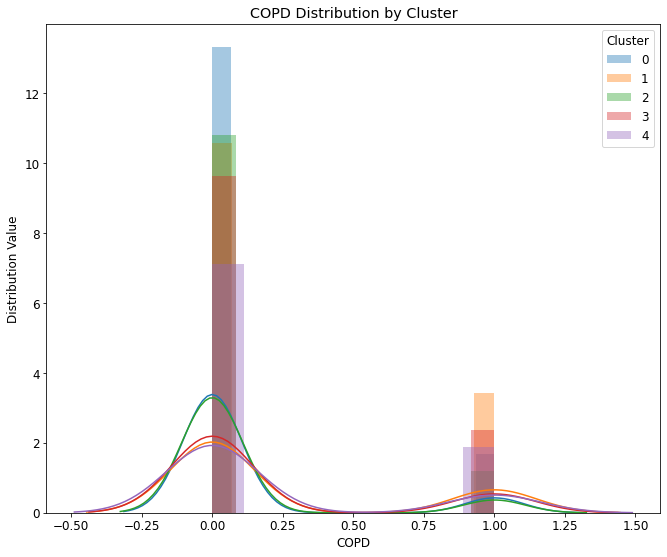

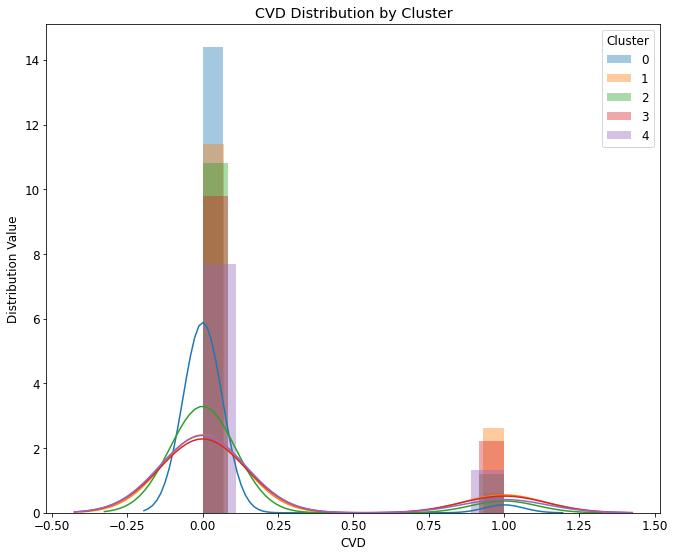

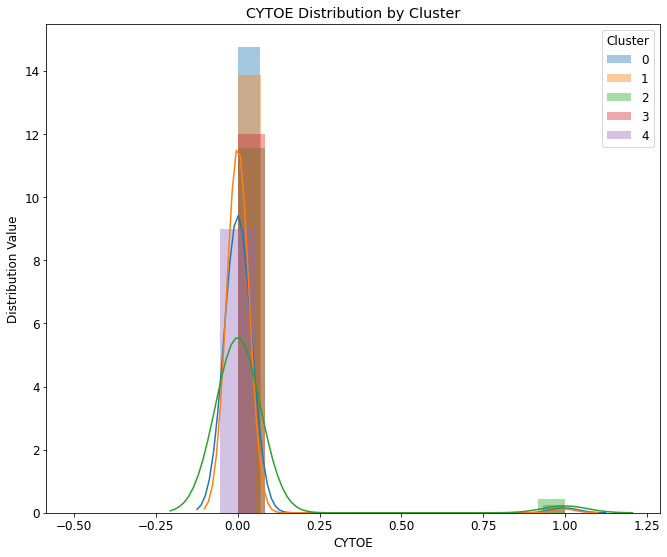

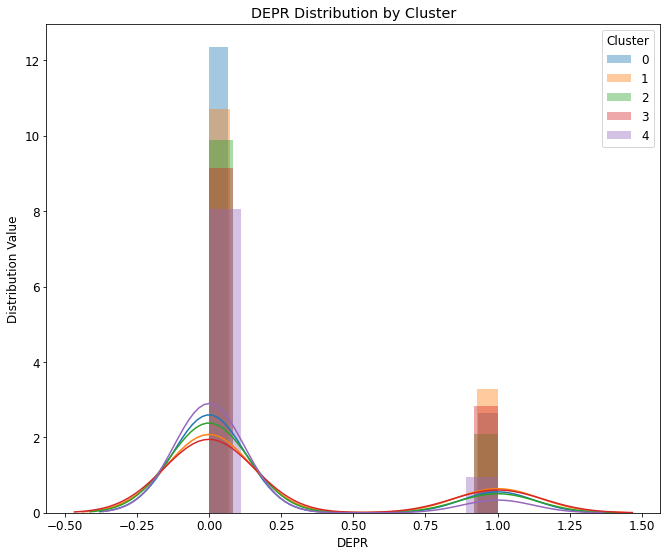

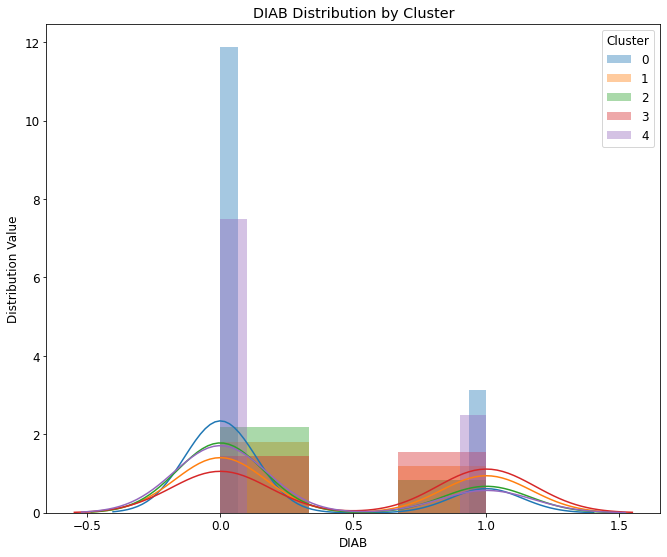

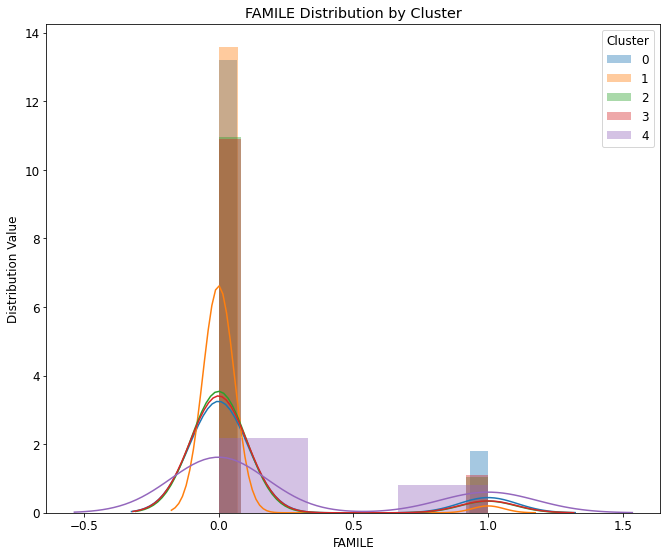

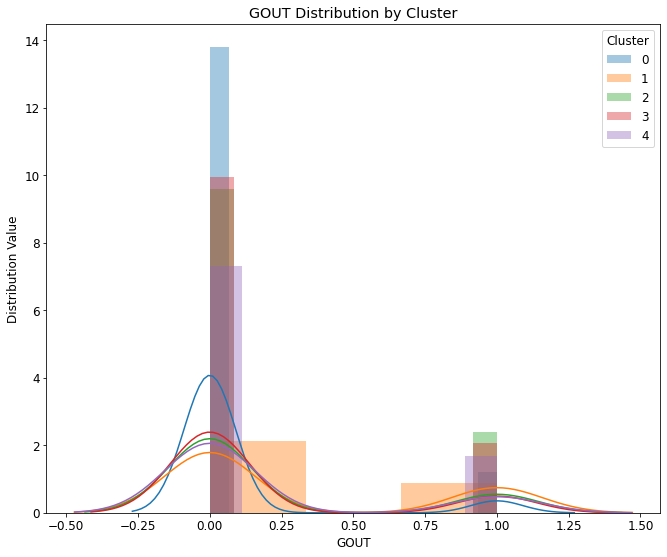

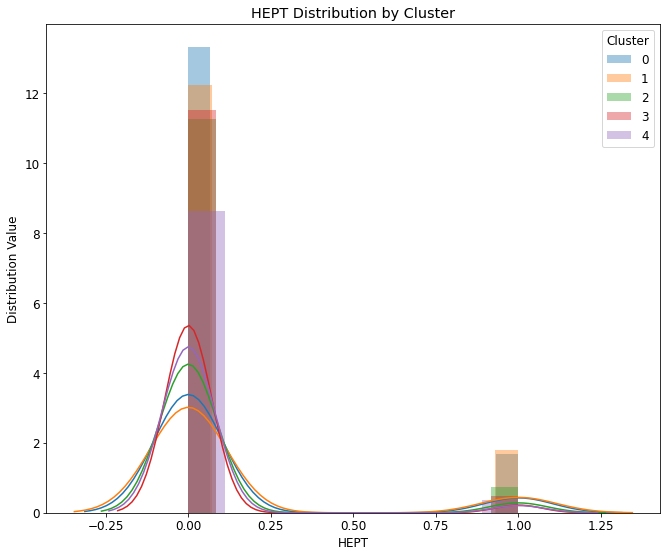

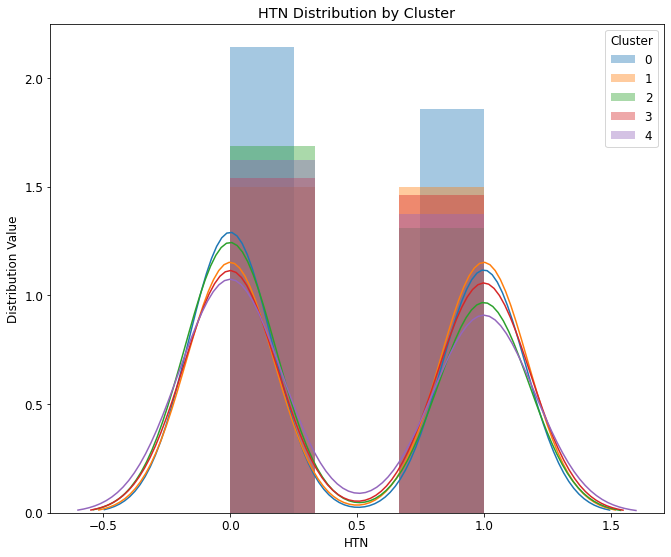

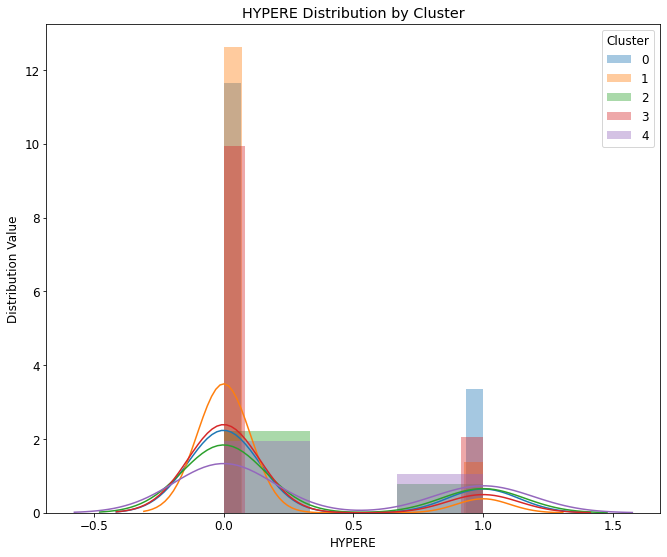

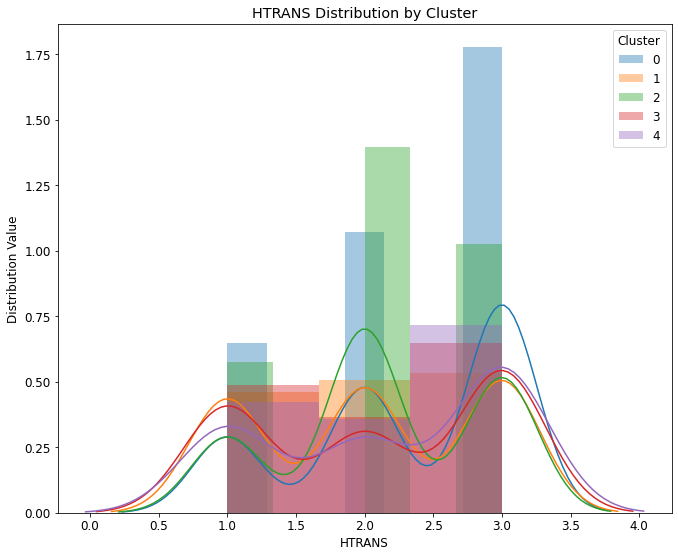

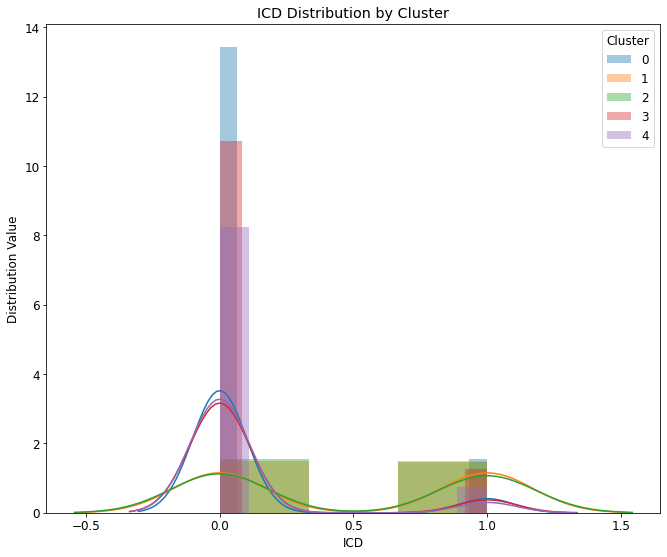

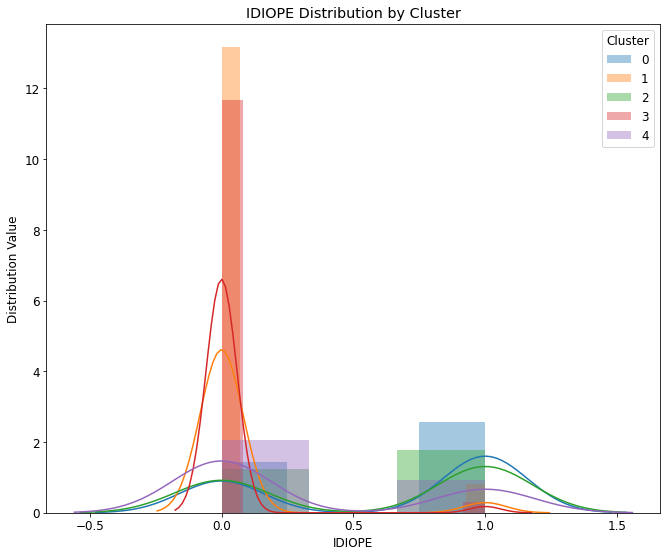

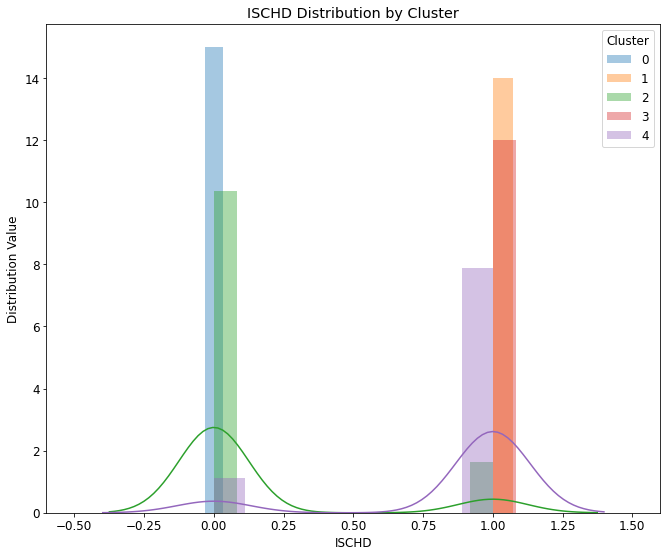

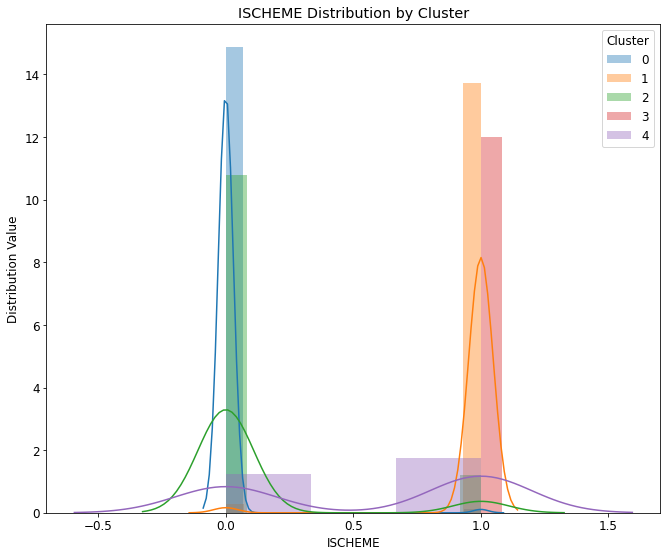

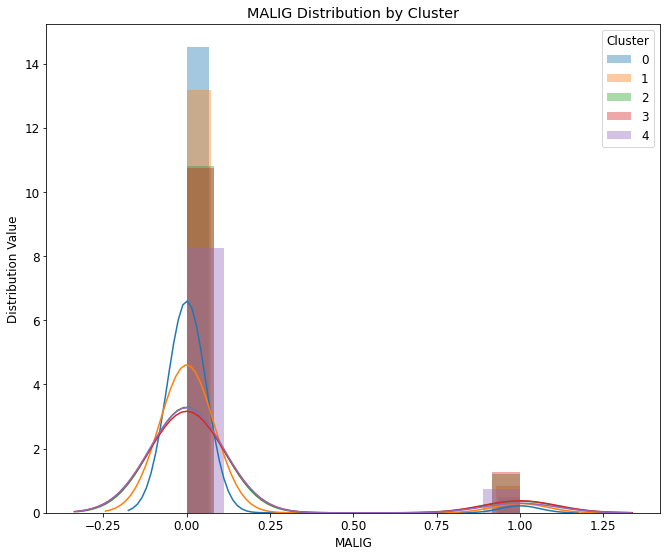

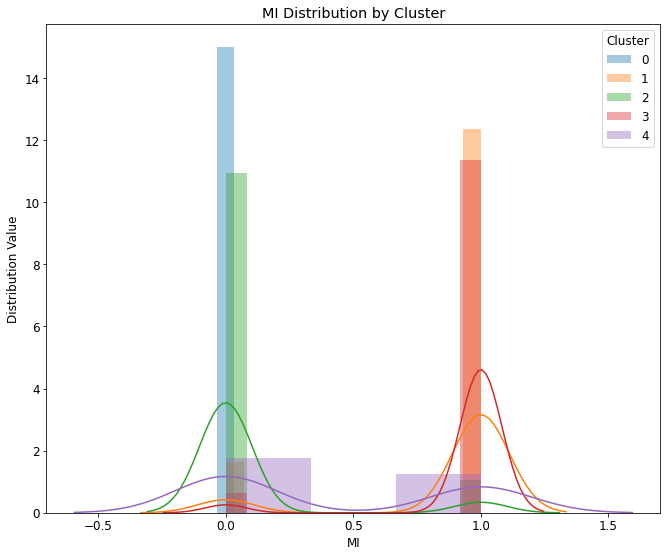

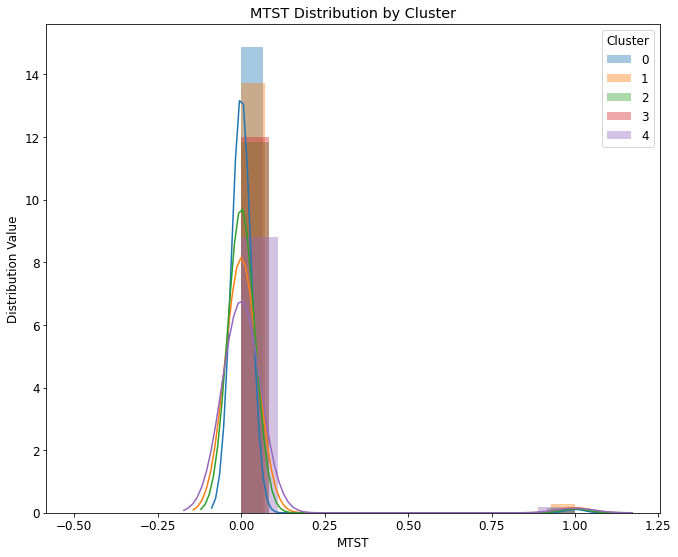

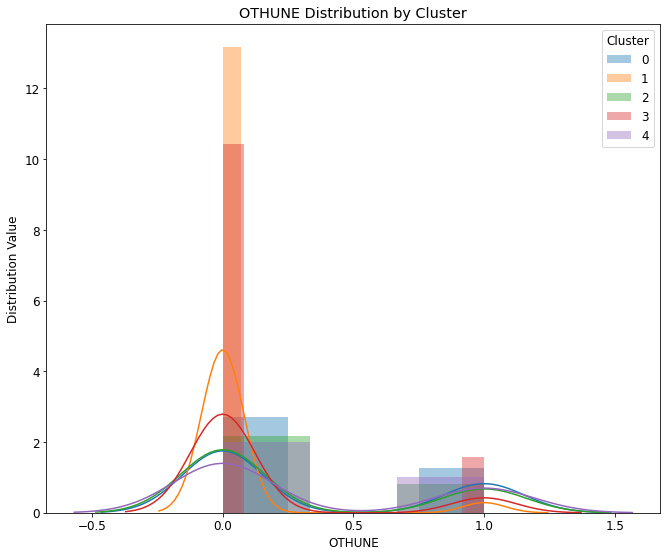

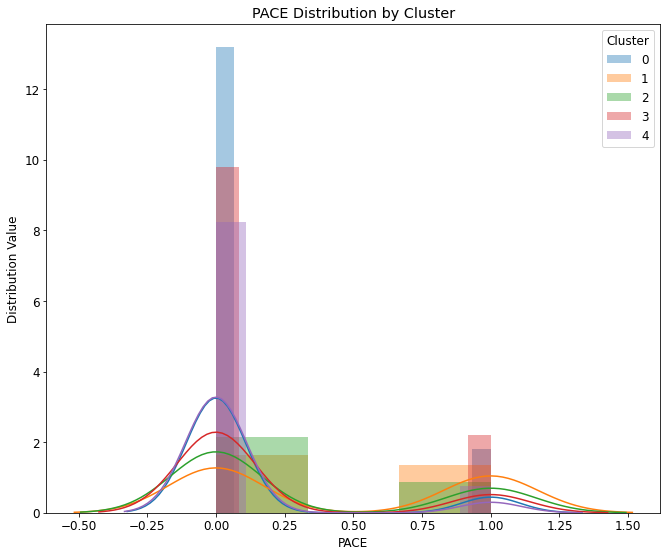

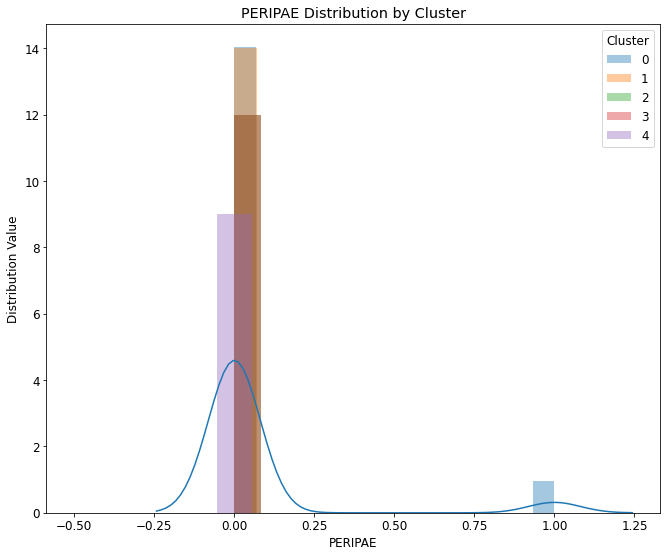

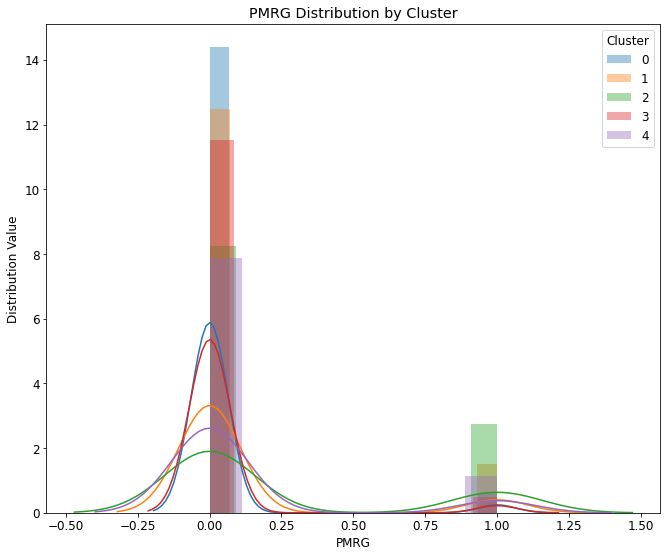

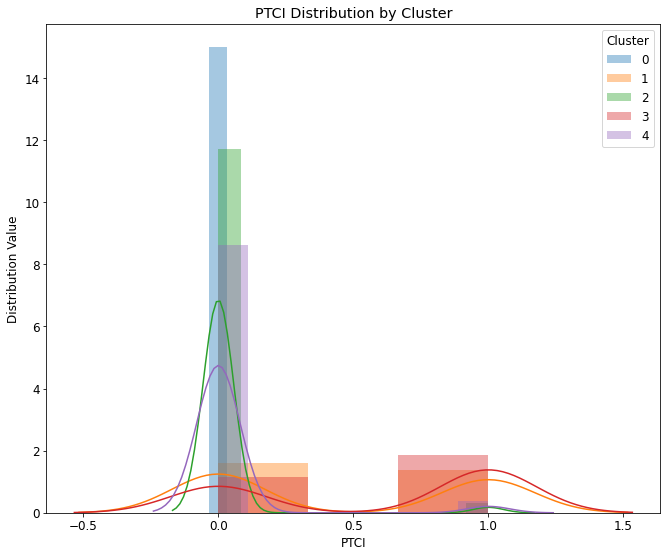

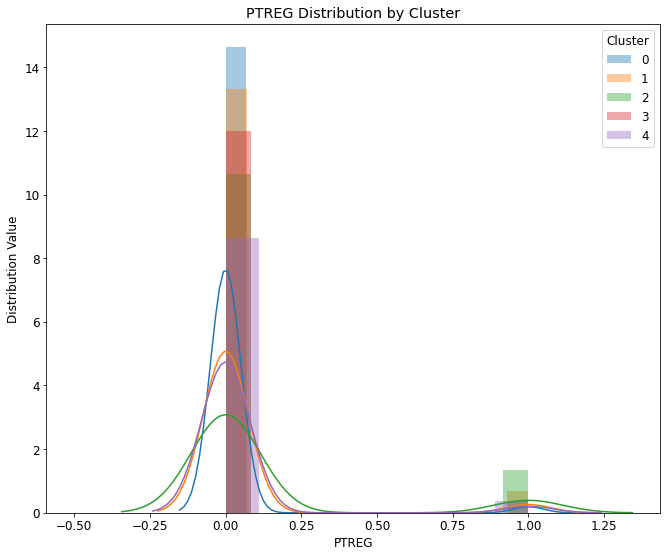

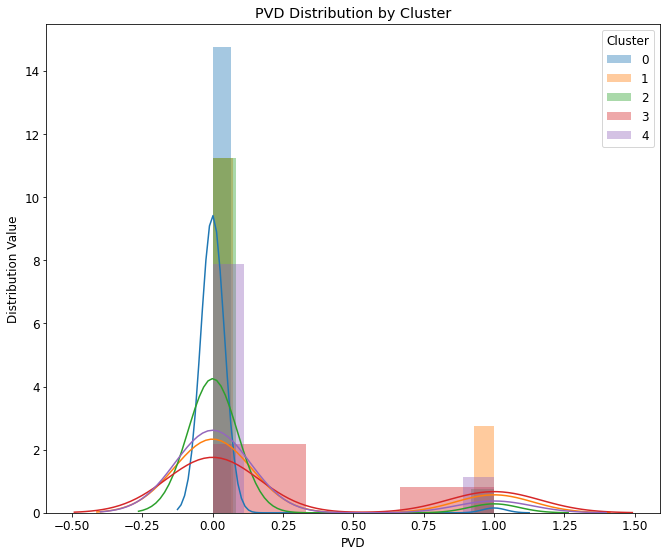

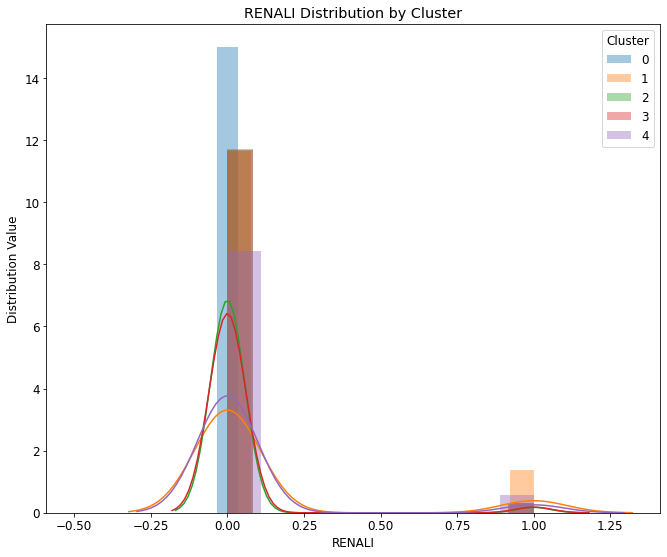

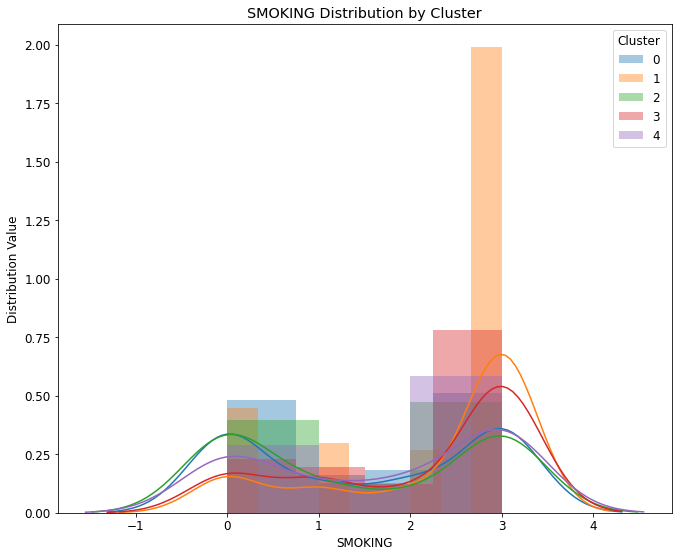

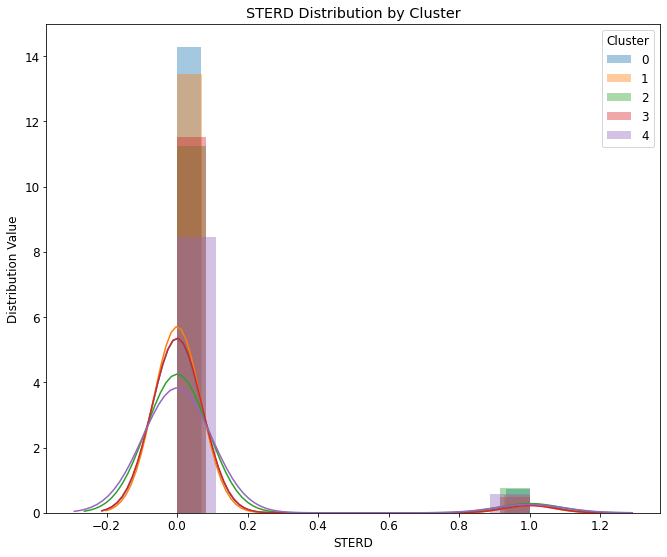

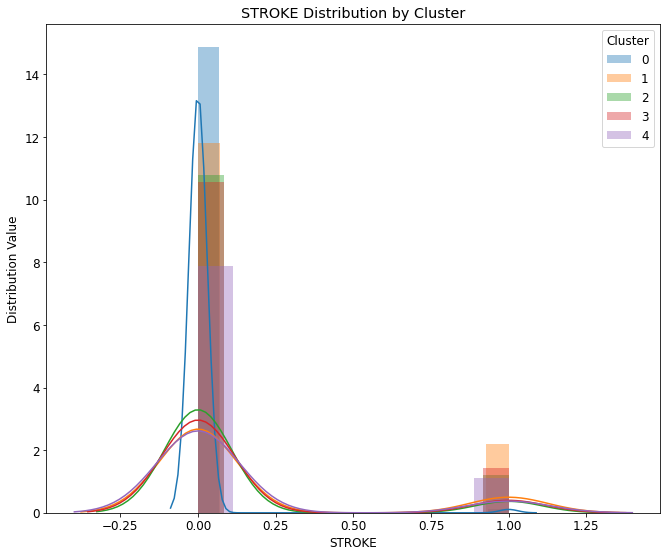

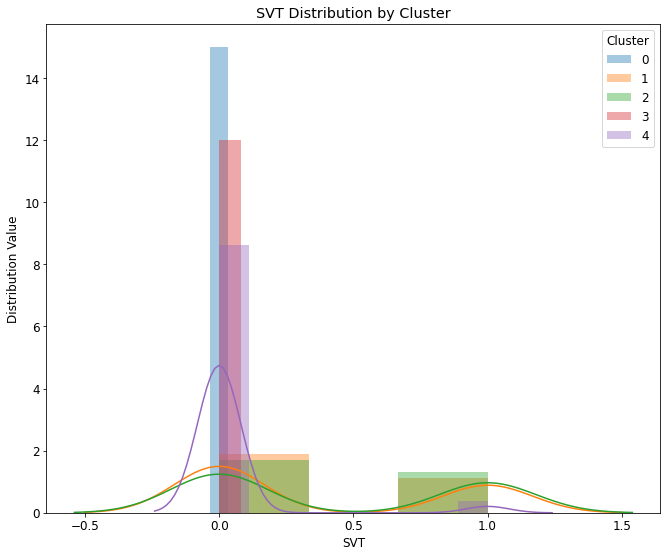

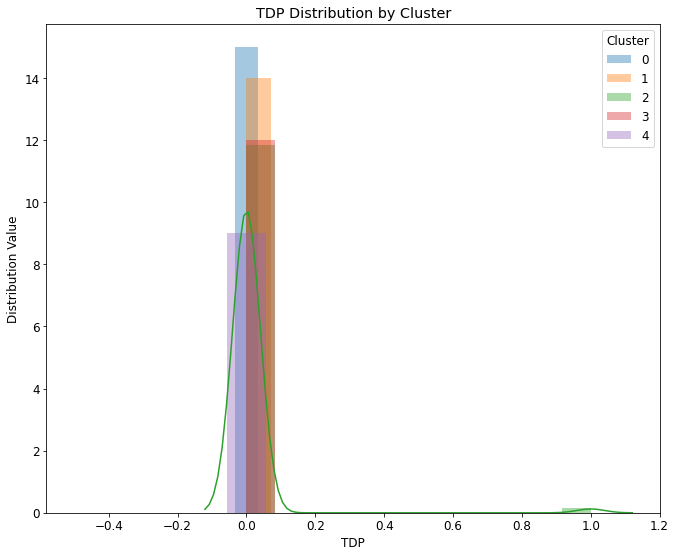

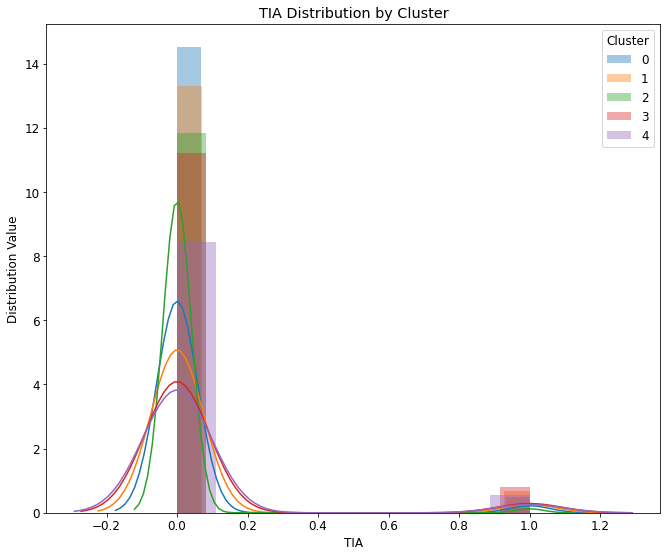

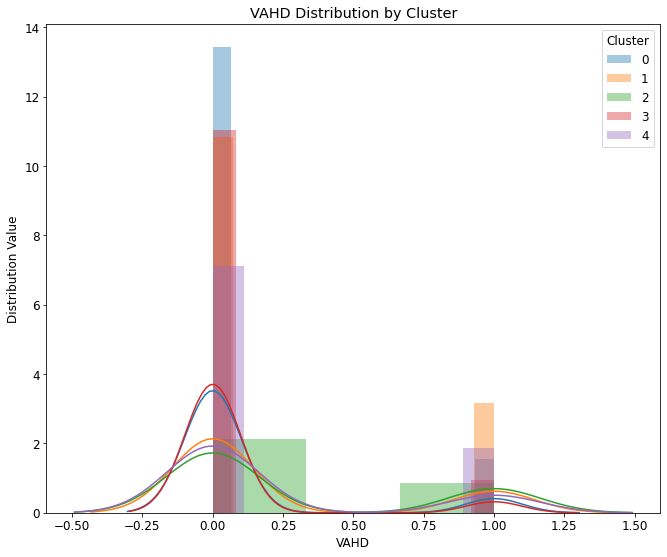

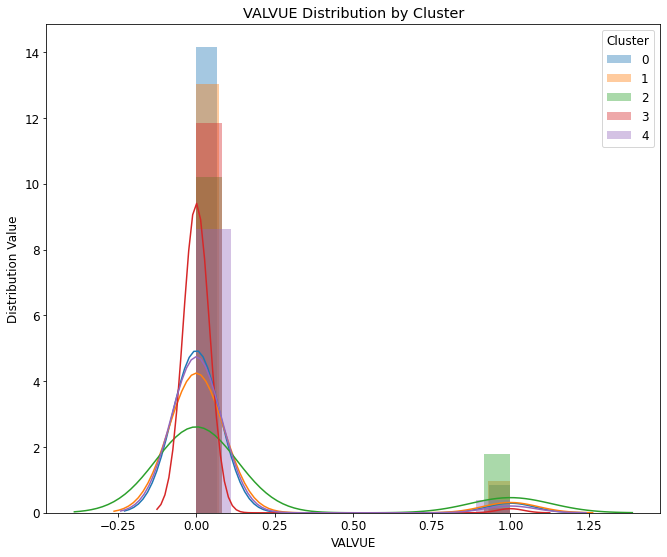

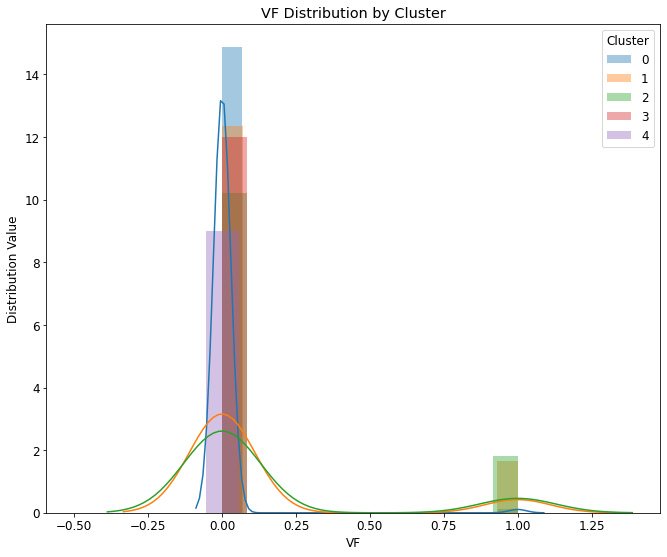

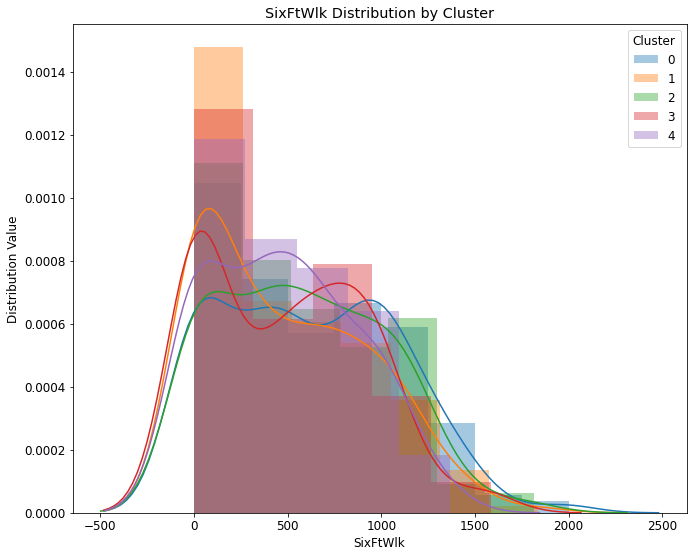

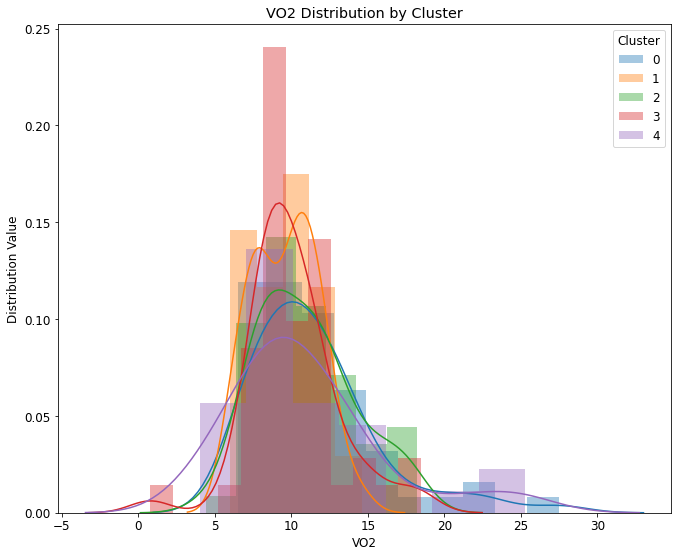

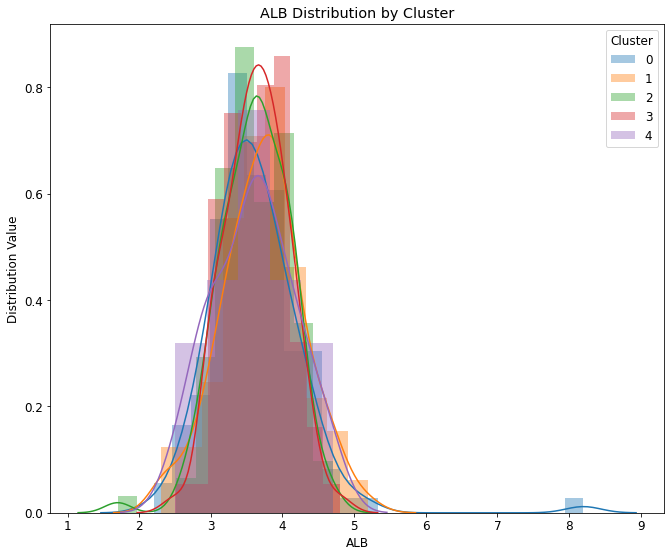

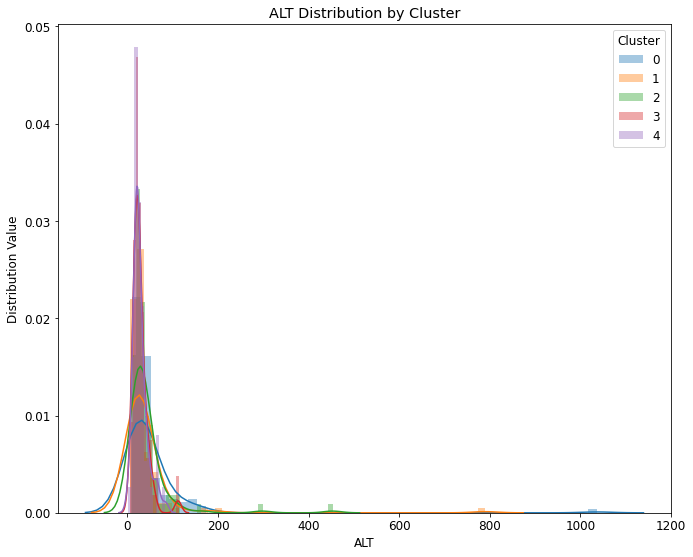

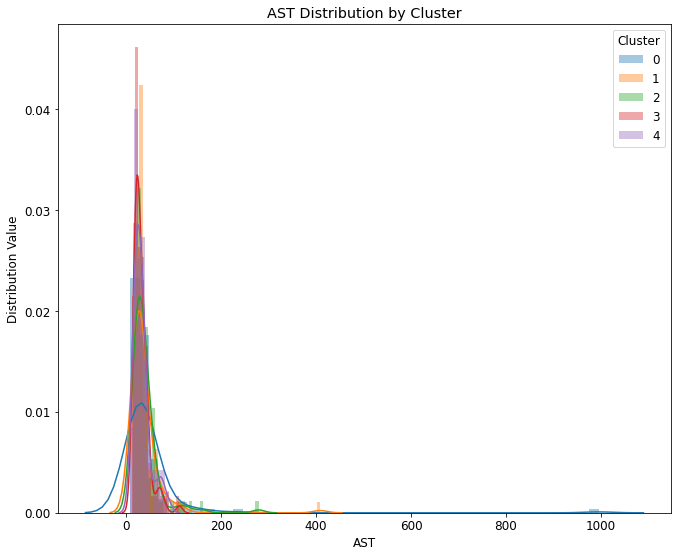

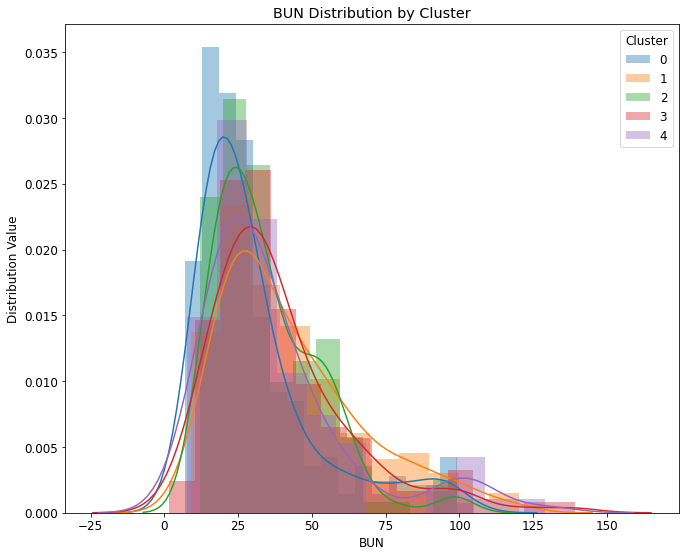

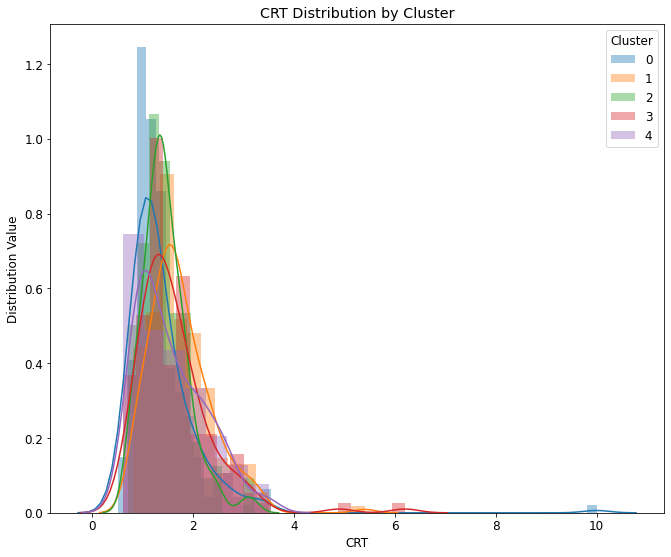

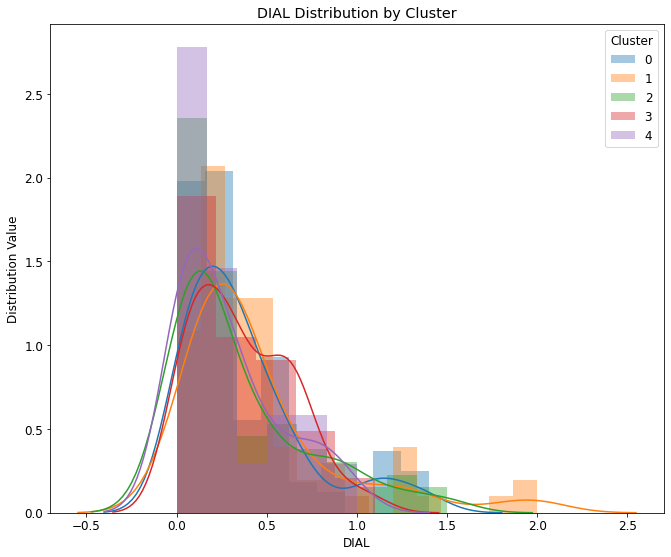

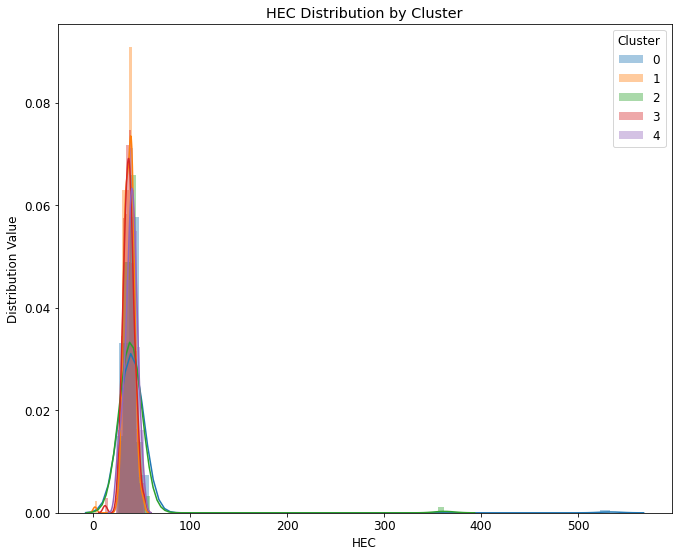

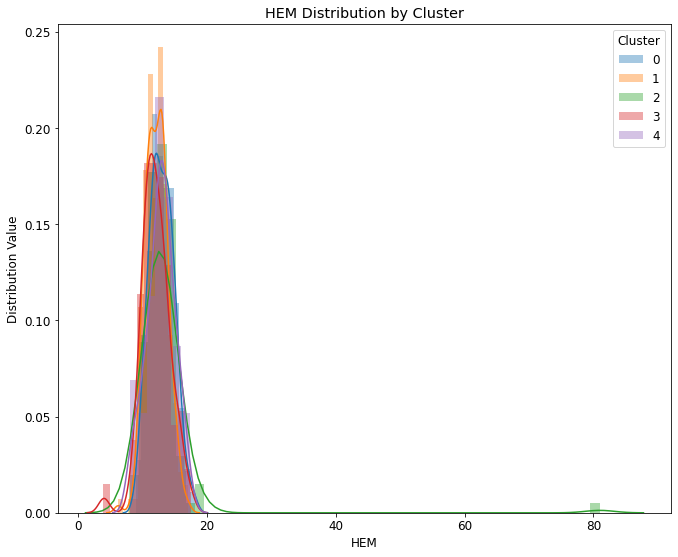

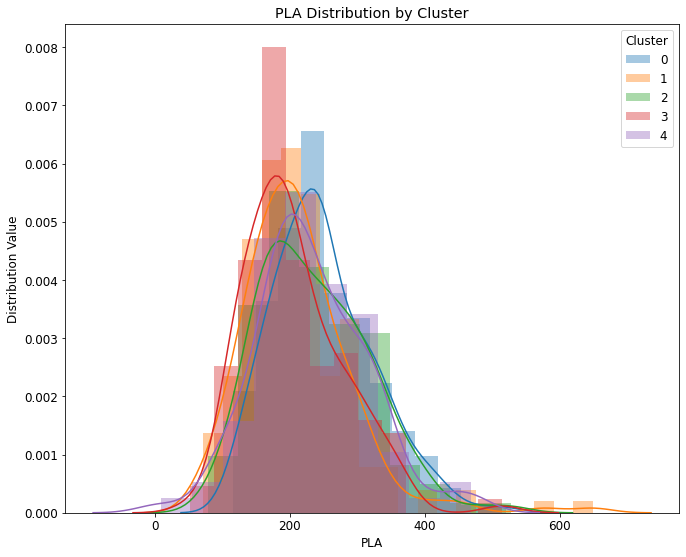

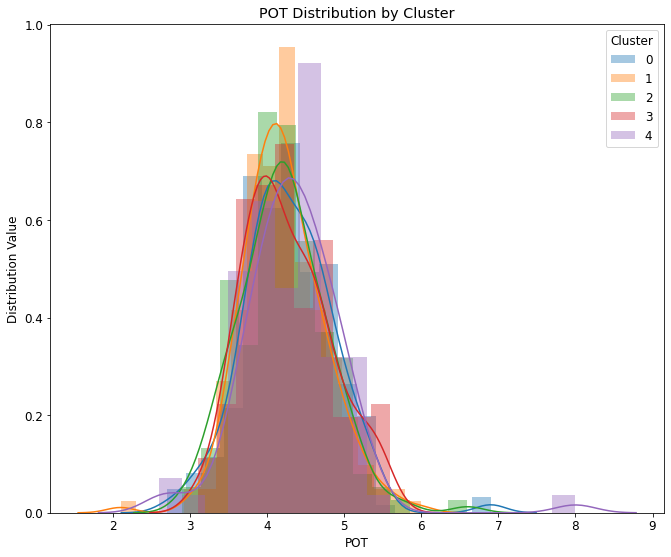

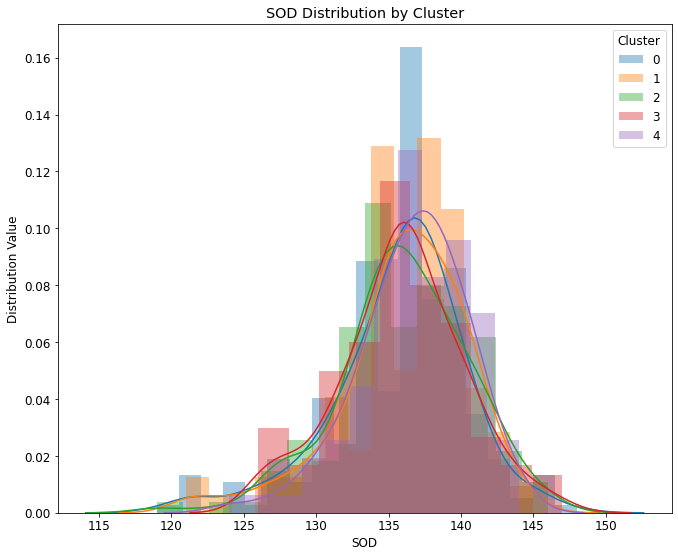

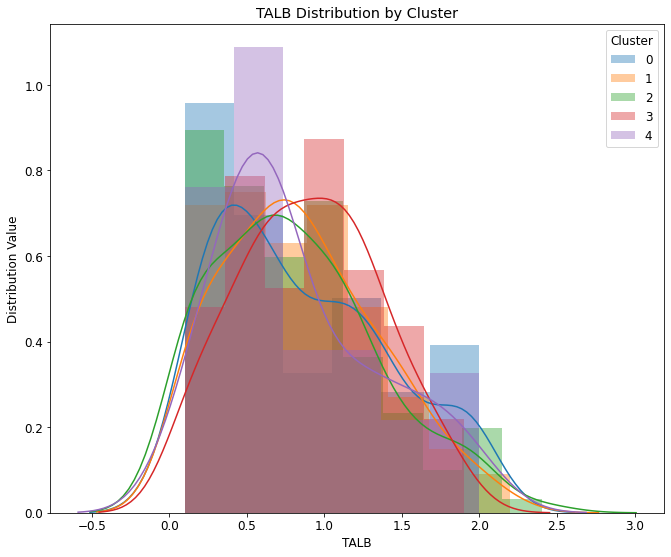

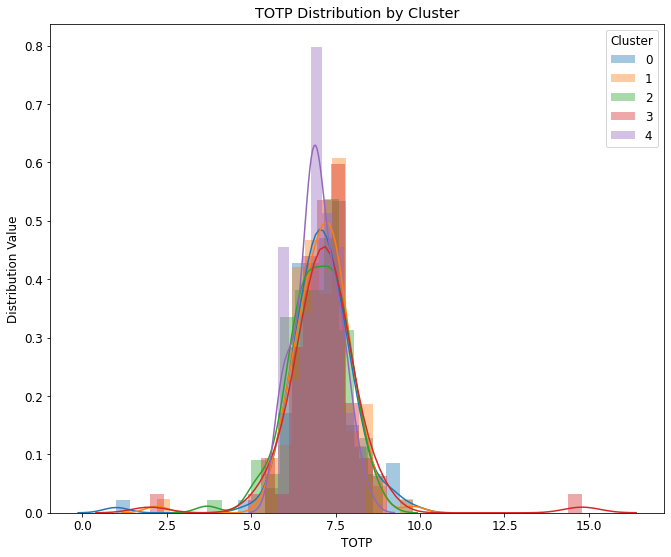

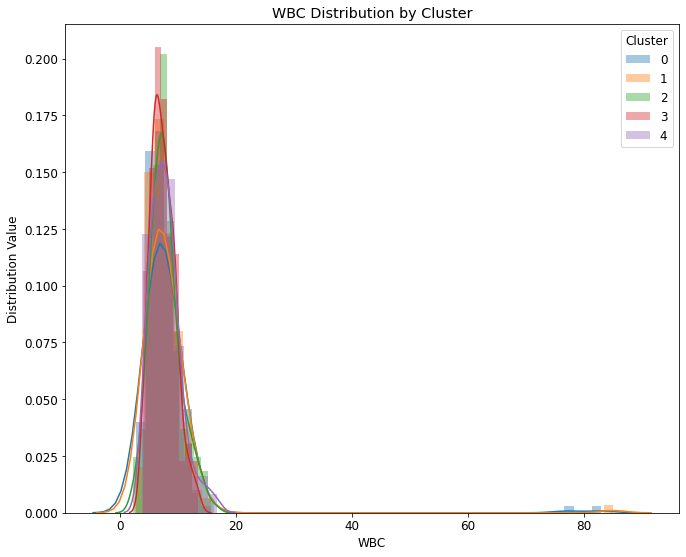

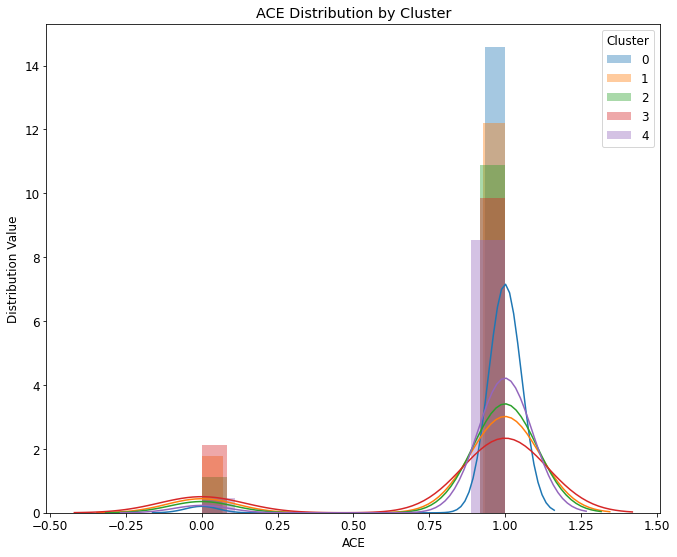

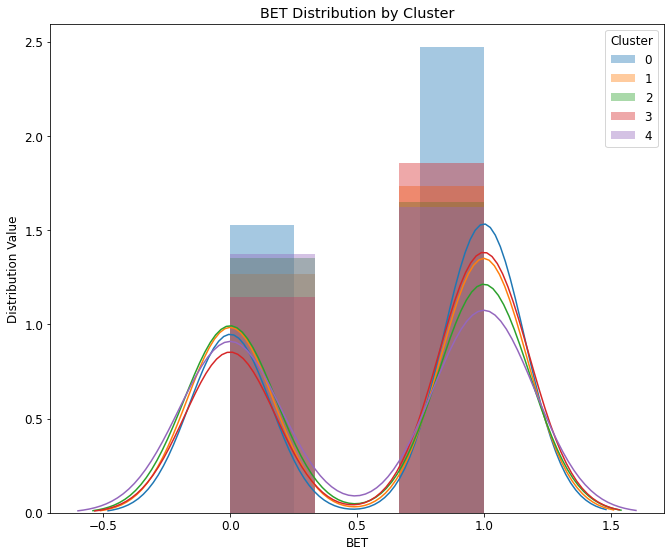

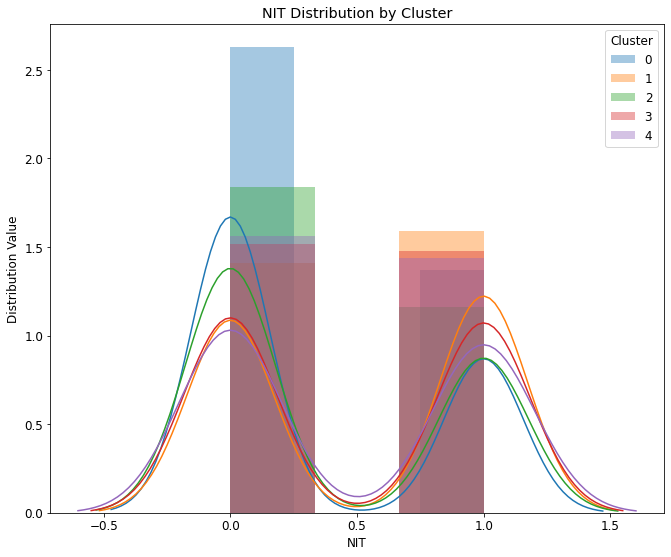

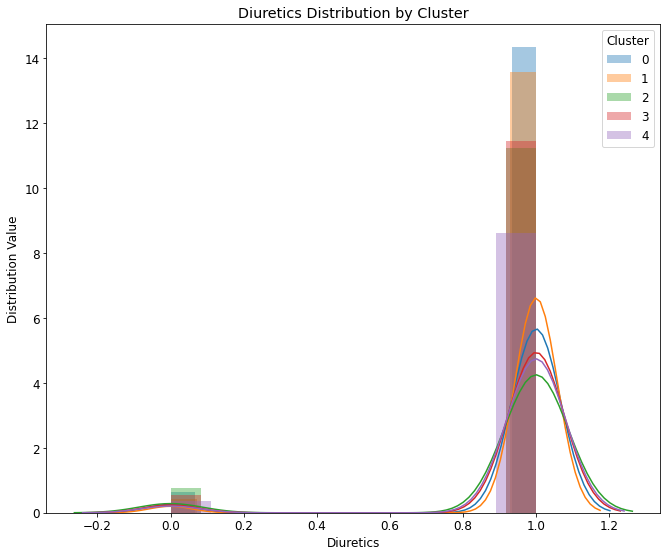

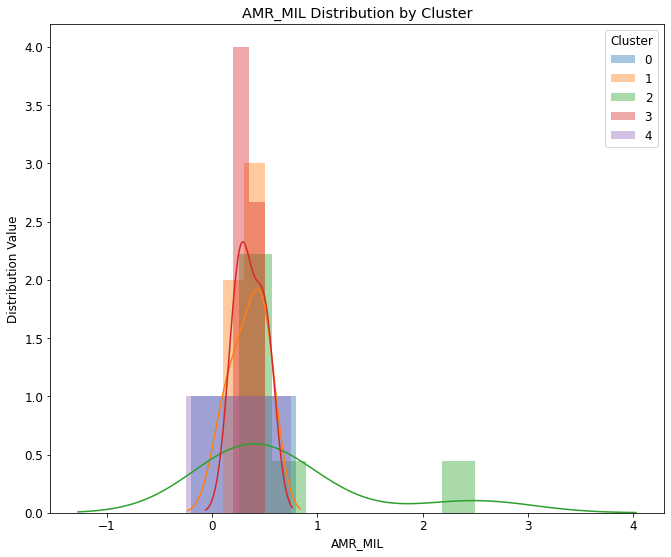

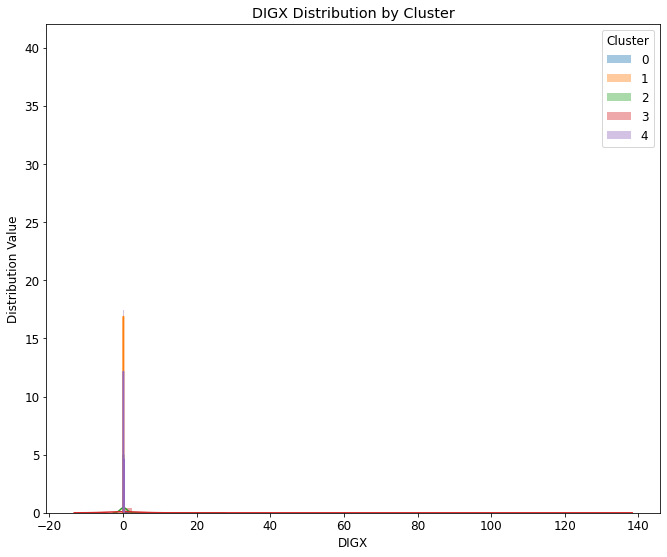

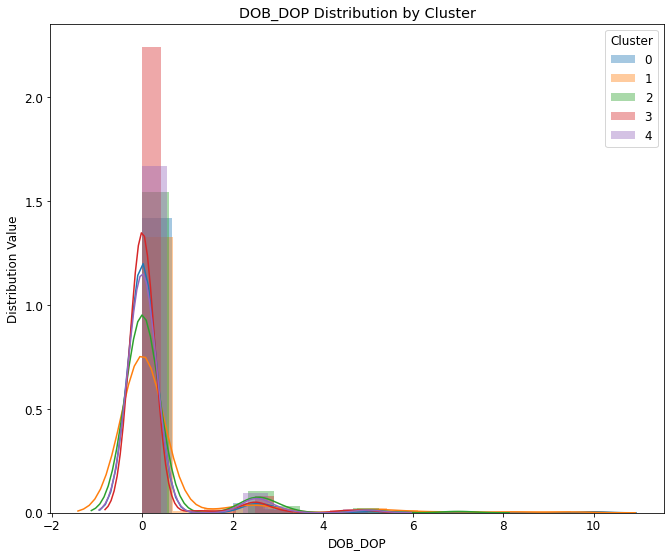

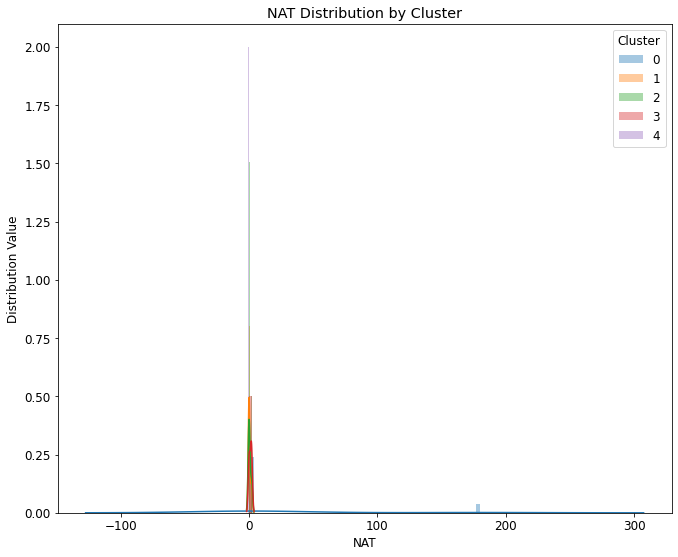

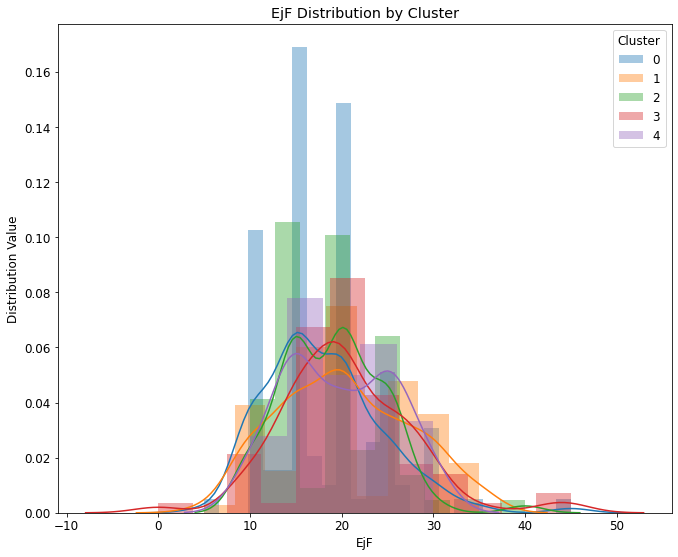

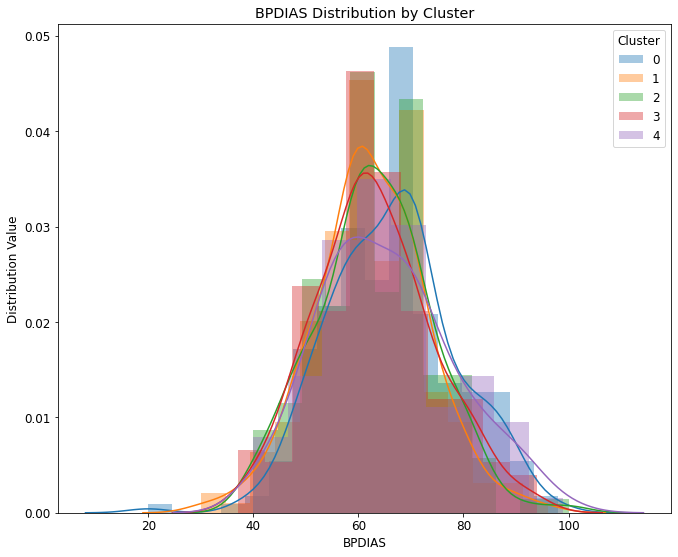

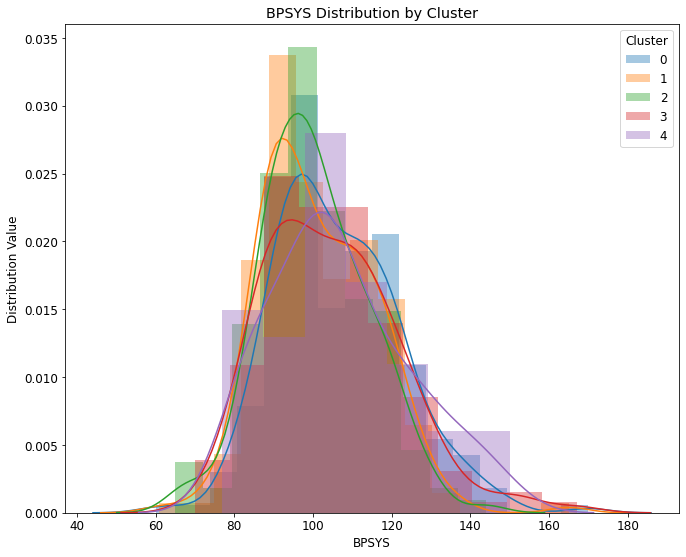

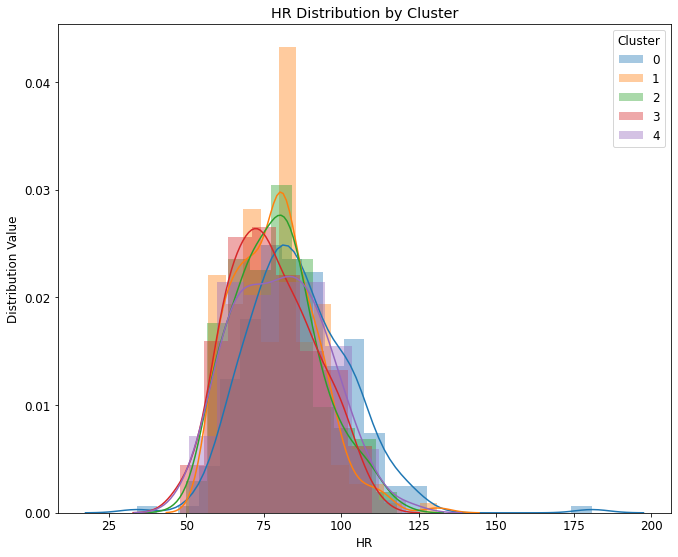

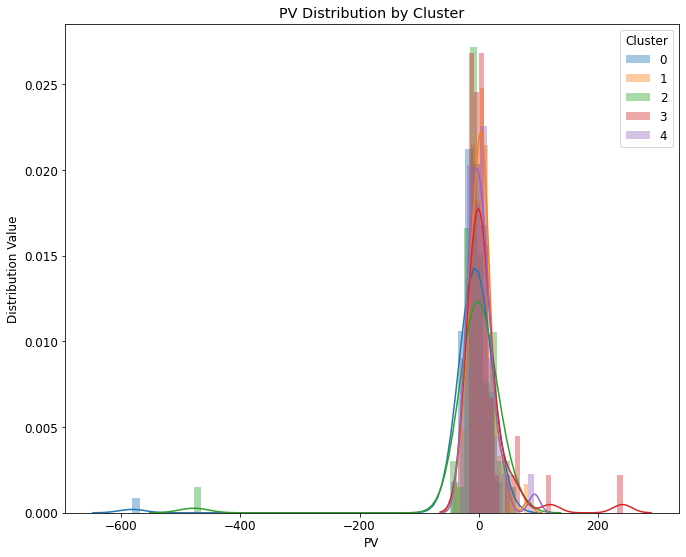

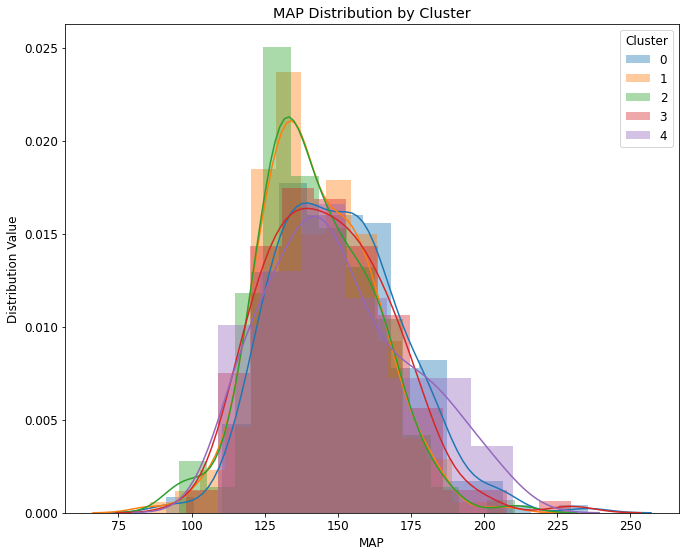

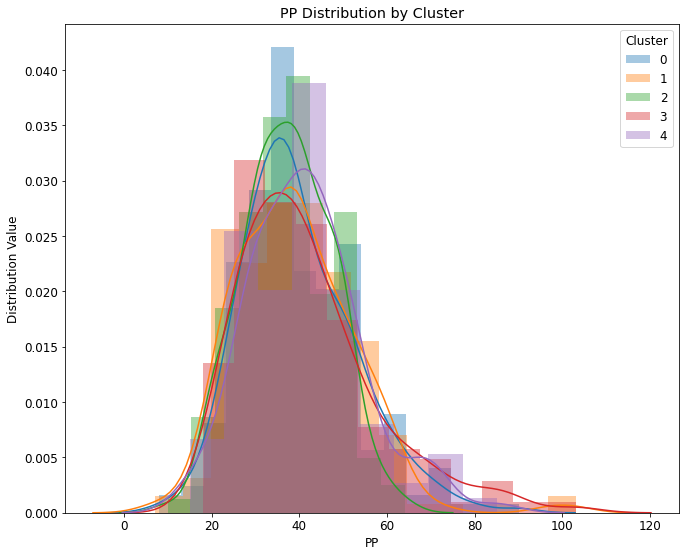

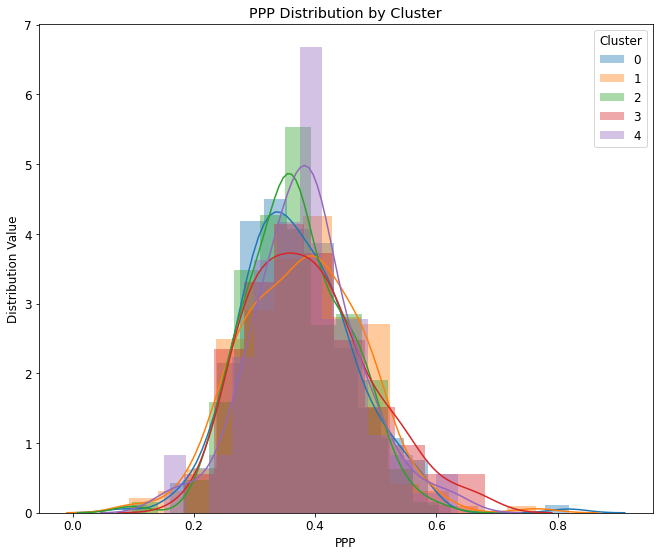

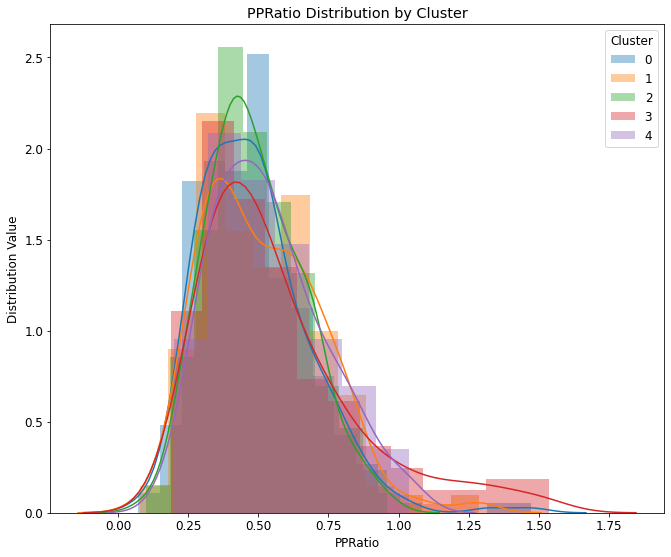

In [20]:
colss = ['Age', 'Gender', 'Race', 'Wt', 'BMI', 'InitialHospDays', 'TotalHospDays', 'NYHA', 'MLHFS', 'AF', 'AlchE', 'ANGP', 'AOREG', 'AOST', 'ARRH', 'CABG', 'CARREST', 'COPD', 'CVD', 'CYTOE', 'DEPR', 'DIAB', 'FAMILE', 'GOUT', 'HEPT', 'HTN', 'HYPERE', 'HTRANS', 'ICD', 'IDIOPE', 'ISCHD', 'ISCHEME', 'MALIG', 'MI', 'MTST', 'OTHUNE', 'PACE', 'PERIPAE', 'PMRG', 'PTCI', 'PTREG', 'PVD', 'RENALI', 'SMOKING', 'STERD', 'STROKE', 'SVT', 'TDP', 'TIA', 'VAHD', 'VALVUE', 'VF', 'SixFtWlk', 'VO2', 'ALB', 'ALT', 'AST', 'BUN', 'CRT', 'DIAL', 'HEC', 'HEM', 'PLA', 'POT', 'SOD', 'TALB', 'TOTP', 'WBC', 
                                                   'ACE', 'BET', 'NIT', 'Diuretics', 'AMR_MIL', 'DIGX', 'DOB_DOP', 'NAT', 'EjF', 'BPDIAS', 'BPSYS', 'HR', 'PV', 'MAP', 'PP', 'PPP', 'PPRatio']
distPlotsForClusters(cls=clusters, cols=colss, name="AllData")

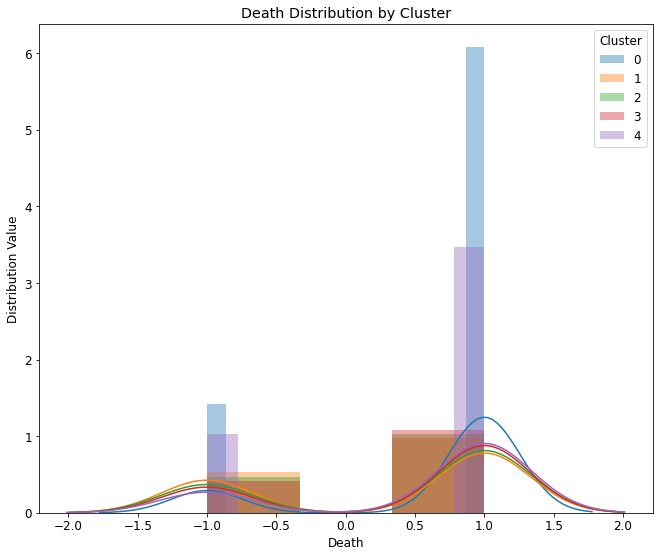

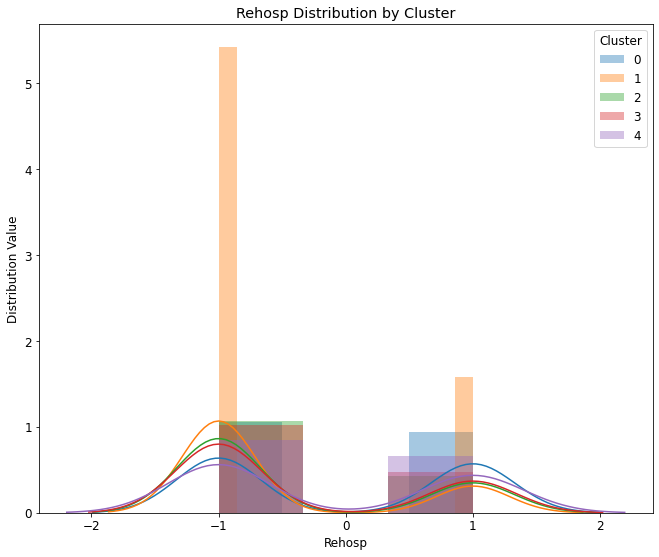

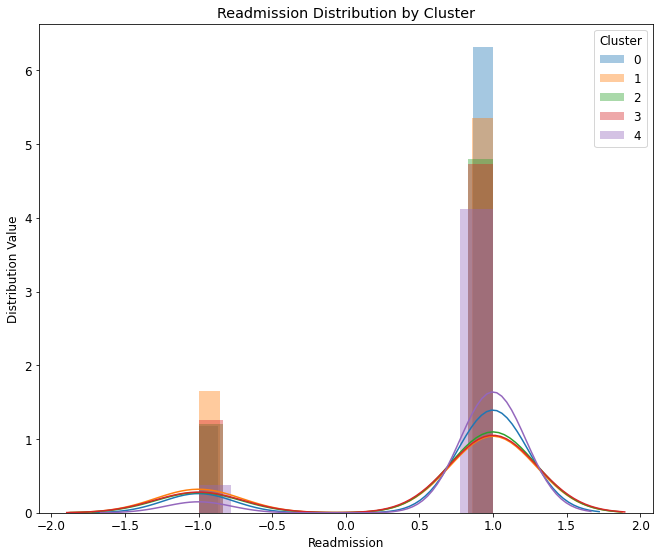

In [21]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss, name="AllData")

In [22]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData.csv")

In [23]:
allDF.to_csv("Clustered_allDataDF.csv")

Save preprocessed data  
Cluster --> Score  
0 --> 5  
1 --> 2  
2 --> 1  
3 --> 4  
4 --> 3  

In [24]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(2)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
    
allDF['Score'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(1)
    elif c == 2:
        labels.append(2)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
allDF['ScoreDeath'] = labels

#Rehosp Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(1)
    elif c == 2:
        labels.append(2)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
allDF['ScoreRehosp'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(2)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
allDF['ScoreReadmission'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])
allDF = allDF.drop(columns=["Rehosp"])
allDF = allDF.drop(columns=["Readmission"])

allDF

Age  Gender  Race          Wt        BMI  InitialHospDays  \
DEIDNUM                                                               
72       88.0     2.0   1.0   57.100000  26.424175              9.0   
72       88.0     2.0   1.0   52.000000  24.064047              9.0   
81       69.0     1.0   1.0  102.363636  32.307675              5.0   
81       69.0     1.0   1.0  100.454545  31.705134              5.0   
86       56.0     2.0   2.0   98.636364  40.016375              3.0   
...       ...     ...   ...         ...        ...              ...   
99302    41.0     1.0   2.0   97.400000  40.541103             21.0   
99912    46.0     1.0   1.0   78.636364  25.677180              2.0   
99912    46.0     1.0   1.0   78.200000  25.534694              2.0   
99935    64.0     2.0   1.0   77.700000  32.762692              3.0   
99935    64.0     2.0   1.0         NaN        NaN              3.0   

         TotalHospDays  NYHA  MLHFS   AF  ...     HR         PV         MAP  \
DEIDNUM                                   ...                                 
72                16.0   4.0   76.0  1.0  ...  104.0  12.452563  139.333333   
72                16.0   3.0   76.0  1.0  ...   92.0  12.452563  126.000000   
81                13.0   4.0   21.0  1.0  ...   70.0  -3.346568  125.333333   
81                13.0   2.0   21.0  1.0  ...   72.0  -3.346568  105.666667   
86                 3.0   4.0    NaN  0.0  ...   86.0   5.478621  146.666667   
...                ...   ...    ...  ...  ...    ...        ...         ...   
99302             21.0   NaN   79.0  0.0  ...   75.0  25.535155  130.000000   
99912              2.0   4.0   89.0  0.0  ...   67.0 -13.911732  174.666667   
99912              2.0   3.0   89.0  0.0  ...   60.0 -13.911732  140.666667   
99935             16.0   3.0  101.0  0.0  ...   86.0        NaN  135.333333   
99935             16.0   NaN  101.0  0.0  ...   87.0        NaN  153.333333   

           PP       PPP   PPRatio  Score  ScoreDeath  ScoreRehosp  \
DEIDNUM                                                             
72       26.0  0.276596  0.250000      2           1            1   
72       26.0  0.302326  0.282609      2           1            1   
81       32.0  0.363636  0.457143      1           2            2   
81       34.0  0.441558  0.472222      1           2            2   
86       30.0  0.300000  0.348837      5           5            5   
...       ...       ...       ...    ...         ...          ...   
99302    55.0  0.550000  0.733333      1           2            2   
99912    38.0  0.316667  0.567164      5           5            5   
99912    24.0  0.255319  0.400000      5           5            5   
99935    42.0  0.428571  0.488372      3           3            3   
99935    70.0  0.583333  0.804598      3           3            3   

         ScoreReadmission  
DEIDNUM                    
72                      2  
72                      2  
81                      1  
81                      1  
86                      5  
...                   ...  
99302                   1  
99912                   5  
99912                   5  
99935                   3  
99935                   3  

[866 rows x 89 columns]

In [25]:
allDF.to_csv("../Data/Preprocessed Data/Cluster_AllData.csv")